### *Import Standard Libraries*

In [1]:
#Libraries for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import os
import re
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import tqdm

#Mosde
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

### *Hypothesis Generation*

- Manual transmition drivers are more likely to claim.
- Old cars are likely to claim.
- Drivers living in places with high population density are likley to claim.
- Younger drivers are more likely to claim.
- Premium hatch backs are more likely claim.
- Drivers owning cars with high maximum torque are more likely to claim.
- Drivers without ESC present are more likely to claim.
- Drivers owning cars without parking camera's are more likely to claim.
- Drivers owning cars without rear brakes will claim.
- Drivers owning cars with manual steering type are more likely to claim.
- The longer the policy term ....


### *Data Preprocessing*

#### *Load Data*

In [2]:
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')

In [3]:
df_train.head(10)

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.60,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.60,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.60,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.80,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.00,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
5,ID00006,1.018709,0.07,0.519231,C6,13051,3,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,1.5 L U2 CRDi,6,Yes,Yes,Yes,Yes,Yes,Disc,1493,4,Automatic,6,Power,5.20,4300,1790,1635,1720,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
6,ID00007,0.097992,0.16,0.403846,C7,6112,4,B2,M5,Diesel,200Nm@3000rpm,88.77bhp@4000rpm,1.5 Turbocharged Revotorq,2,No,Yes,No,Yes,No,Drum,1497,4,Manual,5,Electric,5.00,3990,1755,1523,1490,No,No,No,No,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0
7,ID00008,0.509085,0.14,0.423077,C8,8794,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2,No,Yes,No,Yes,No,Drum,1197,4,Manual,5,Electric,4.80,3845,1735,1530,1335,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
8,ID00009,0.282394,0.07,0.298077,C7,6112,3,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,1.5 L U2 CRDi,6,Yes,Yes,Yes,Yes,Yes,Disc,1493,4,Automatic,6,Power,5.20,4300,1790,1635,1720,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
9,ID00010,0.566255,0.04,0.442308,C9,17804,1,B2,M7,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K Series Engine,6,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.85,3990,1745,1500,1410,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,0


In [4]:
df_train['transmission_type'].value_counts()

Manual       38181
Automatic    20411
Name: transmission_type, dtype: int64

In [5]:
df_test['transmission_type'].value_counts()

Manual       25392
Automatic    13671
Name: transmission_type, dtype: int64

In [6]:
list(df_train.columns)

['policy_id',
 'policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'area_cluster',
 'population_density',
 'make',
 'segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'airbags',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'displacement',
 'cylinder',
 'transmission_type',
 'gear_box',
 'steering_type',
 'turning_radius',
 'length',
 'width',
 'height',
 'gross_weight',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert',
 'ncap_rating',
 'is_claim']

#### *Datatypes*

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

#### *Are these data types correct?*

- Maximum torque and power will be converted to float.

In [8]:
#Let us correct the data types and put them accordinlgy

# To ensure correct imputation method for each feature, change categorical variables that are currently numeric to catogory
change_to_catogorical_list =[]         
change_to_int_list = []
change_to_float_list = []

def change_dtypes(df, *args):
    '''This function performs type casting for all the data types...'''
    df[change_to_catogorical_list] = df[change_to_catogorical_list].astype('category')
    df[change_to_int_list] = df[change_to_int_list].astype('int64')
    df[change_to_float_list] = df[change_to_float_list].astype('float64')
    return df
    

#### *How many variables per datatype?* 

In [9]:

#How many numerical and catogorical variables do we have:
def calc_num_vars(df):
    '''This function calculates the number of variables per data type'''
    numeric_vars=list(df.select_dtypes(include=['int64','float64']).columns)
    categorical_vars=list(df.select_dtypes(include=['category','object']).columns)
    return print(f'All features: {df.shape}\nNumeric variables: {len(numeric_vars)}\nCatogorical variables: {len(categorical_vars)}')

calc_num_vars(df_train)

All features: (58592, 44)
Numeric variables: 16
Catogorical variables: 28


#### *Data Summary*

In [10]:
df_train.describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


#### *Duplicates*

In [11]:
df_train.duplicated().sum()

0

#### *Missing Values*

In [12]:
df_train.isnull().sum().sum()

0

### *EDA*

#### *A closer look at numerical variables*

#### *Range of variables*

In [13]:
numeric_vars=list(df_train.select_dtypes(include=['int64','float64']).columns)
for variable in numeric_vars:
    print(f'range of {variable}: [{df_train[variable].min()}, {df_train[variable].max()}]')

range of policy_tenure: [0.002735272840513, 1.39664107699389]
range of age_of_car: [0.0, 1.0]
range of age_of_policyholder: [0.288461538461538, 1.0]
range of population_density: [290, 73430]
range of make: [1, 5]
range of airbags: [1, 6]
range of displacement: [796, 1498]
range of cylinder: [3, 4]
range of gear_box: [5, 6]
range of turning_radius: [4.5, 5.2]
range of length: [3445, 4300]
range of width: [1475, 1811]
range of height: [1475, 1825]
range of gross_weight: [1051, 1720]
range of ncap_rating: [0, 5]
range of is_claim: [0, 1]


#### *Basic Summary*

#### *Univariate Analysis: Numerical Variables*

In [14]:
# Numerical datatypes
numerical_cols = df_train.select_dtypes(include=['int64','float64','Int64'])[:]
numerical_cols.dtypes

policy_tenure          float64
age_of_car             float64
age_of_policyholder    float64
population_density       int64
make                     int64
airbags                  int64
displacement             int64
cylinder                 int64
gear_box                 int64
turning_radius         float64
length                   int64
width                    int64
height                   int64
gross_weight             int64
ncap_rating              int64
is_claim                 int64
dtype: object

In [15]:
# segregating variables into groups
age_variables = ['policy_tenure','age_of_car','age_of_policyholder']
car_variables = ['displacement','cylinder','gear_box',]  
car_variables1= ['length','width','height',]
car_variables2= ['make','population_density','turning_radius']
car_variables3=['gross_weight','ncap_rating','airbags']

In [16]:
def UVA_numeric(data, var_group):
    '''
    This function takes in a dataframe and a group of integer and float variables
    and plots KDE along with all the descriptive statistics.
    '''
    size = len(var_group)
    plt.figure(figsize = (5*size,8), dpi = 100)
    for j,i in enumerate(var_group):
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max()-data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()
        points = mean-st_dev, mean+st_dev
        plt.subplot(size,size,j+1)
        sns.kdeplot(data[i], shade=True)
        sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
        sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
        sns.scatterplot([mean], [0], color = 'red', label = "mean")
        sns.scatterplot([median], [0], color = 'blue', label = "median")
        plt.xlabel('{}'.format(i), fontsize = 20)
        plt.ylabel('density')
        plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))

#### *Customer Information*

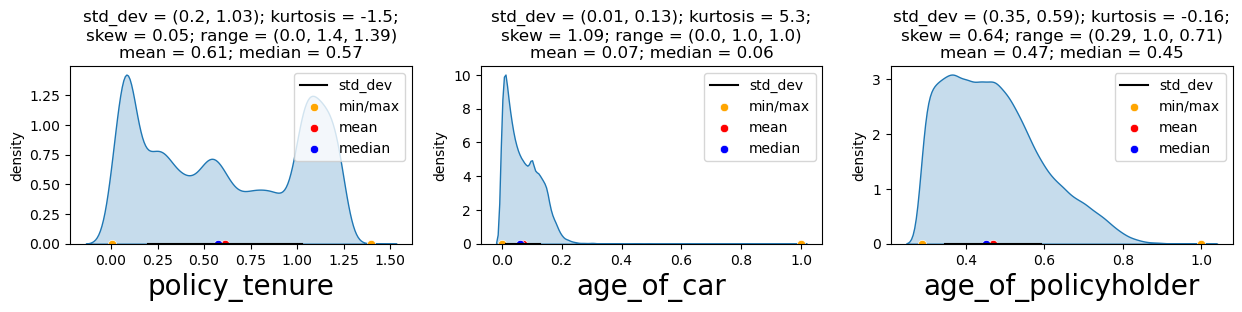

In [17]:
UVA_numeric(df_train,age_variables)

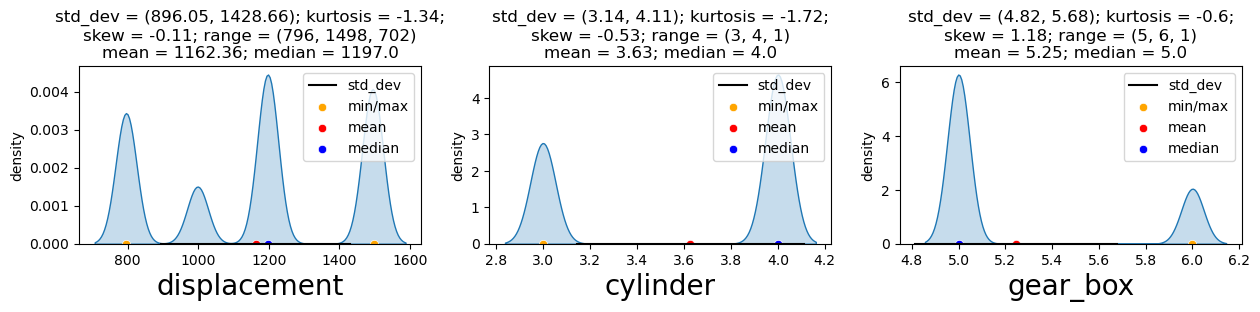

In [18]:
UVA_numeric(df_train,car_variables)

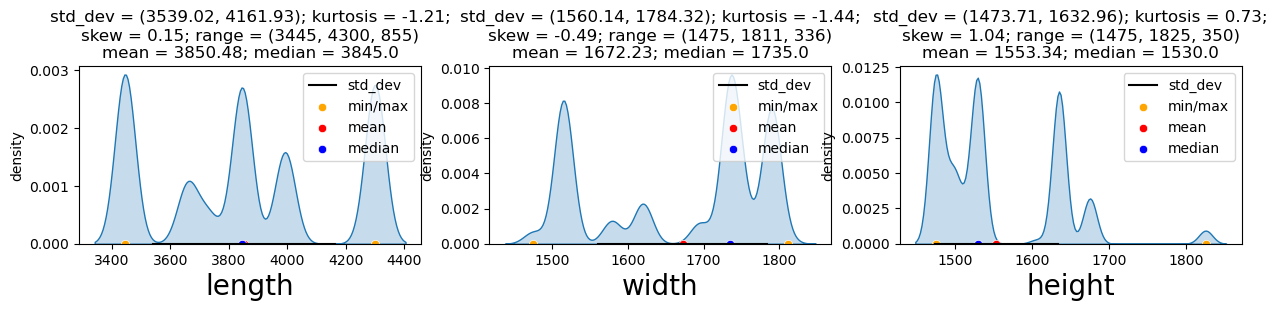

In [19]:
UVA_numeric(df_train,car_variables1)

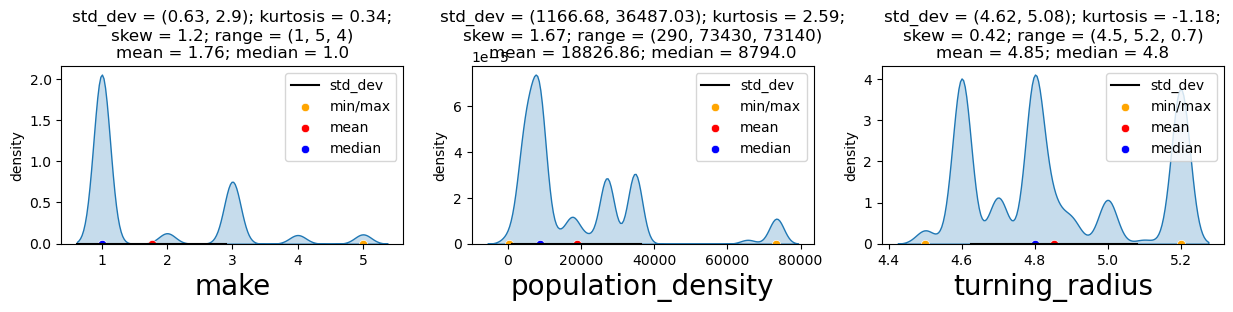

In [20]:
UVA_numeric(df_train,car_variables2)

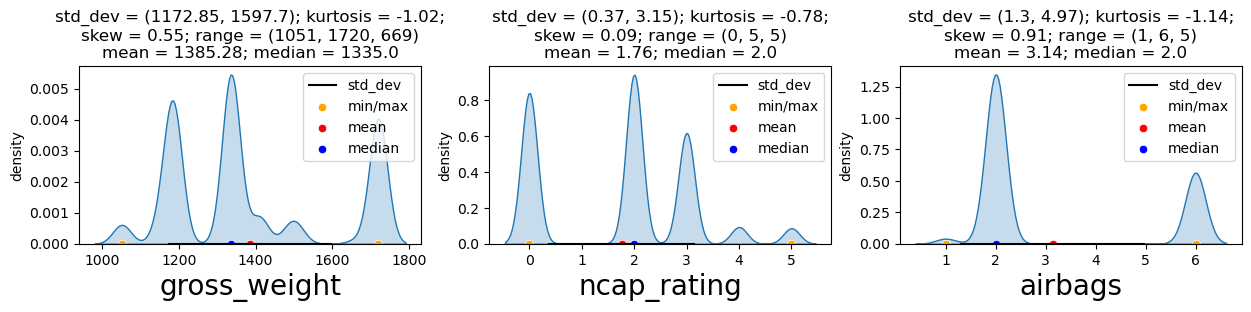

In [21]:
UVA_numeric(df_train,car_variables3)

#### *Sumary:*

#### *Univariate Analysis: Categorical Features*
#### *The target distribuition*

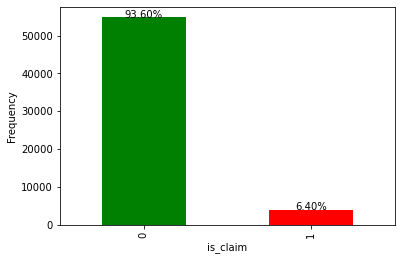

In [22]:
ax=df_train['is_claim'].value_counts().plot.bar(color=['g','r'])
total = float(len(df_train))
plt.ylabel('Frequency')
plt.xlabel('is_claim')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2%}'.format(height/total),
            ha="center")
plt.show()

In [23]:
def UVA_category(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize = (7*size,5), dpi = 100)

  # for every variable
  for j,i in enumerate(var_group):
    norm_count = data[i].value_counts(normalize = True)
    n_uni = data[i].nunique()

  #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.barplot(x=norm_count.index, y=norm_count , order = norm_count.index, orient = 'v')
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('fraction/percent', fontsize = 20)
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))

In [24]:
# Categorical datatypes
categorical_cols = df_train.select_dtypes(include=['object'])[:]
categorical_cols.dtypes

policy_id                           object
area_cluster                        object
segment                             object
model                               object
fuel_type                           object
max_torque                          object
max_power                           object
engine_type                         object
is_esc                              object
is_adjustable_steering              object
is_tpms                             object
is_parking_sensors                  object
is_parking_camera                   object
rear_brakes_type                    object
transmission_type                   object
steering_type                       object
is_front_fog_lights                 object
is_rear_window_wiper                object
is_rear_window_washer               object
is_rear_window_defogger             object
is_brake_assist                     object
is_power_door_locks                 object
is_central_locking                  object
is_power_st

In [25]:
#Breakdown categorical variables for better visualisation of graphs
list_2=['fuel_type','max_torque','max_power',]
list_3=['engine_type','is_esc','is_adjustable_steering',]
list_4=['is_tpms','is_parking_sensors','is_parking_camera',]
list_5=['rear_brakes_type','transmission_type','steering_type',]
list_6=['is_front_fog_lights','is_rear_window_wiper','is_rear_window_washer',]
list_7=['is_rear_window_defogger','is_brake_assist','is_power_door_locks',]
list_8=['is_central_locking','is_power_steering','is_driver_seat_height_adjustable',]
list_9=['is_day_night_rear_view_mirror','is_ecw','is_speed_alert']

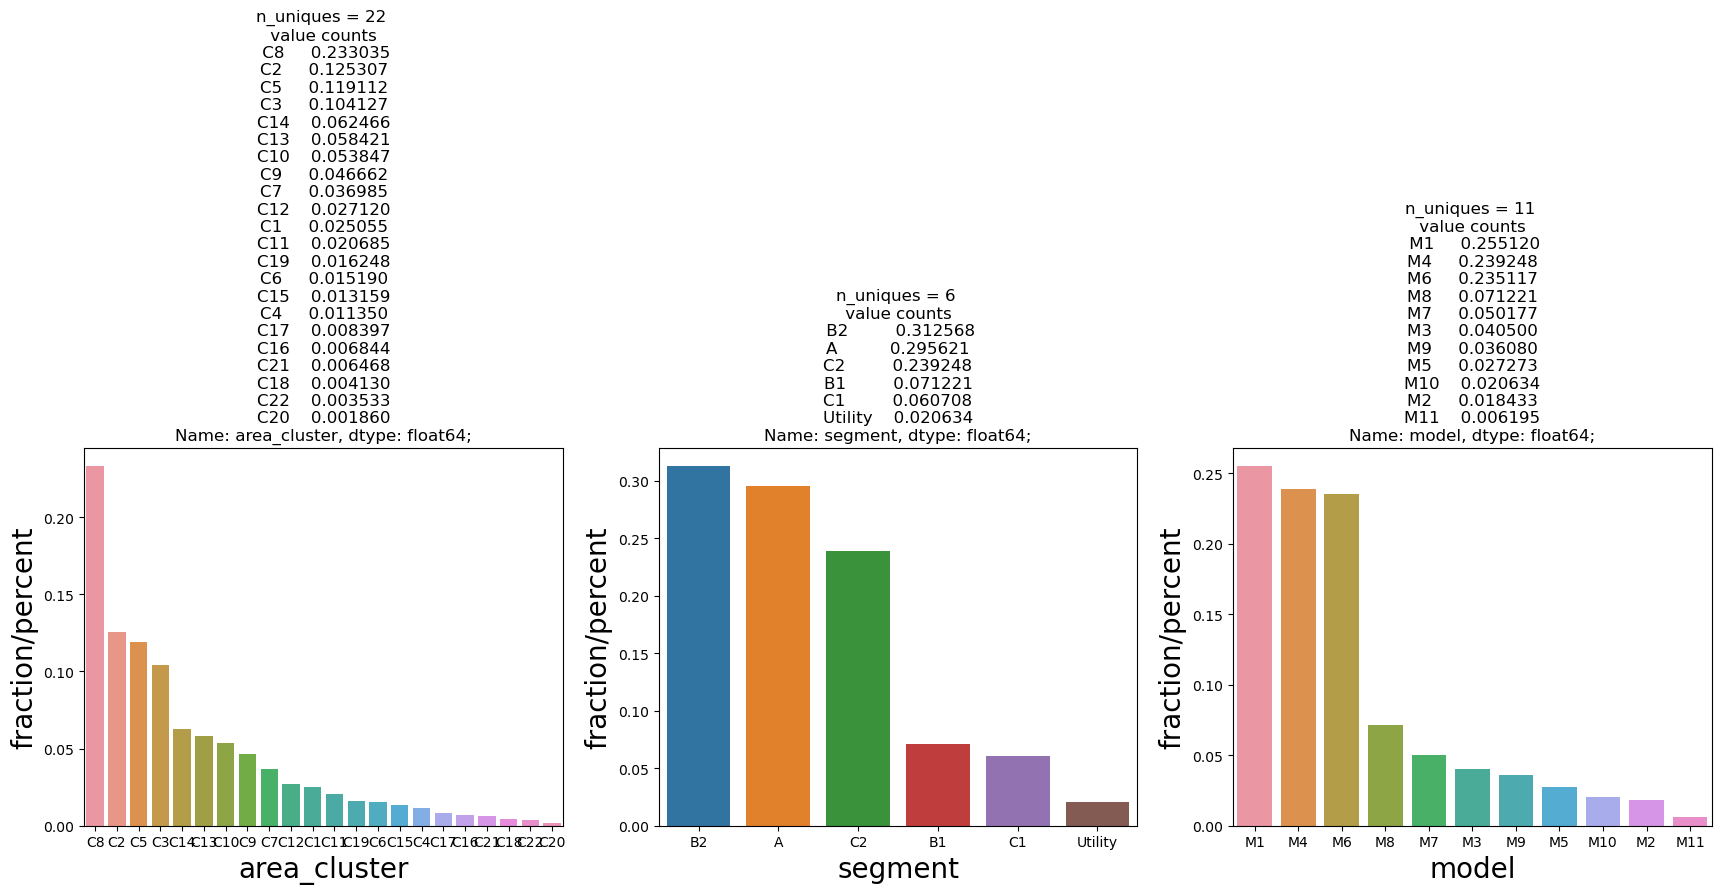

In [26]:
list_1=['area_cluster','segment','model']
UVA_category(df_train, list_1)

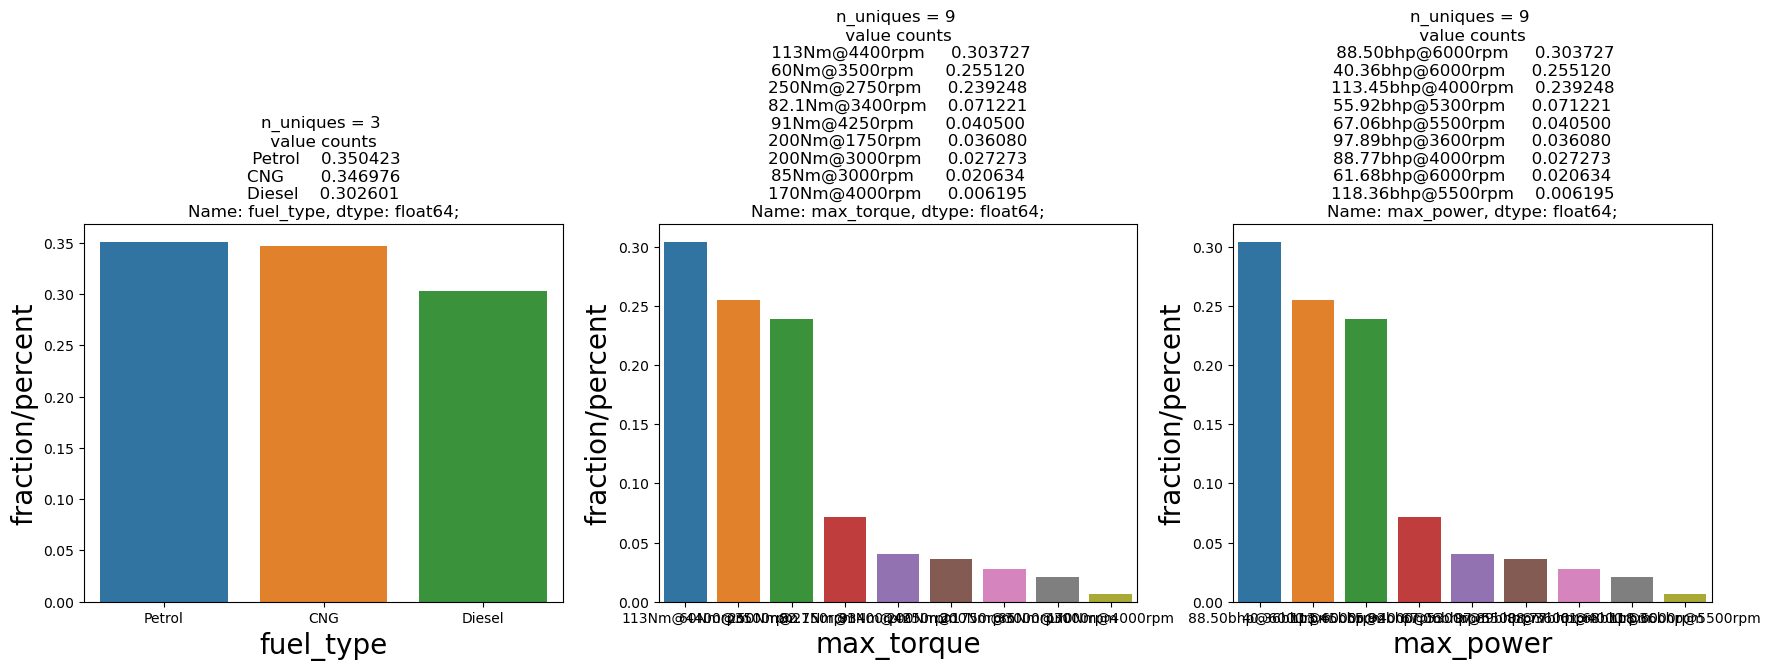

In [27]:
UVA_category(df_train, list_2)

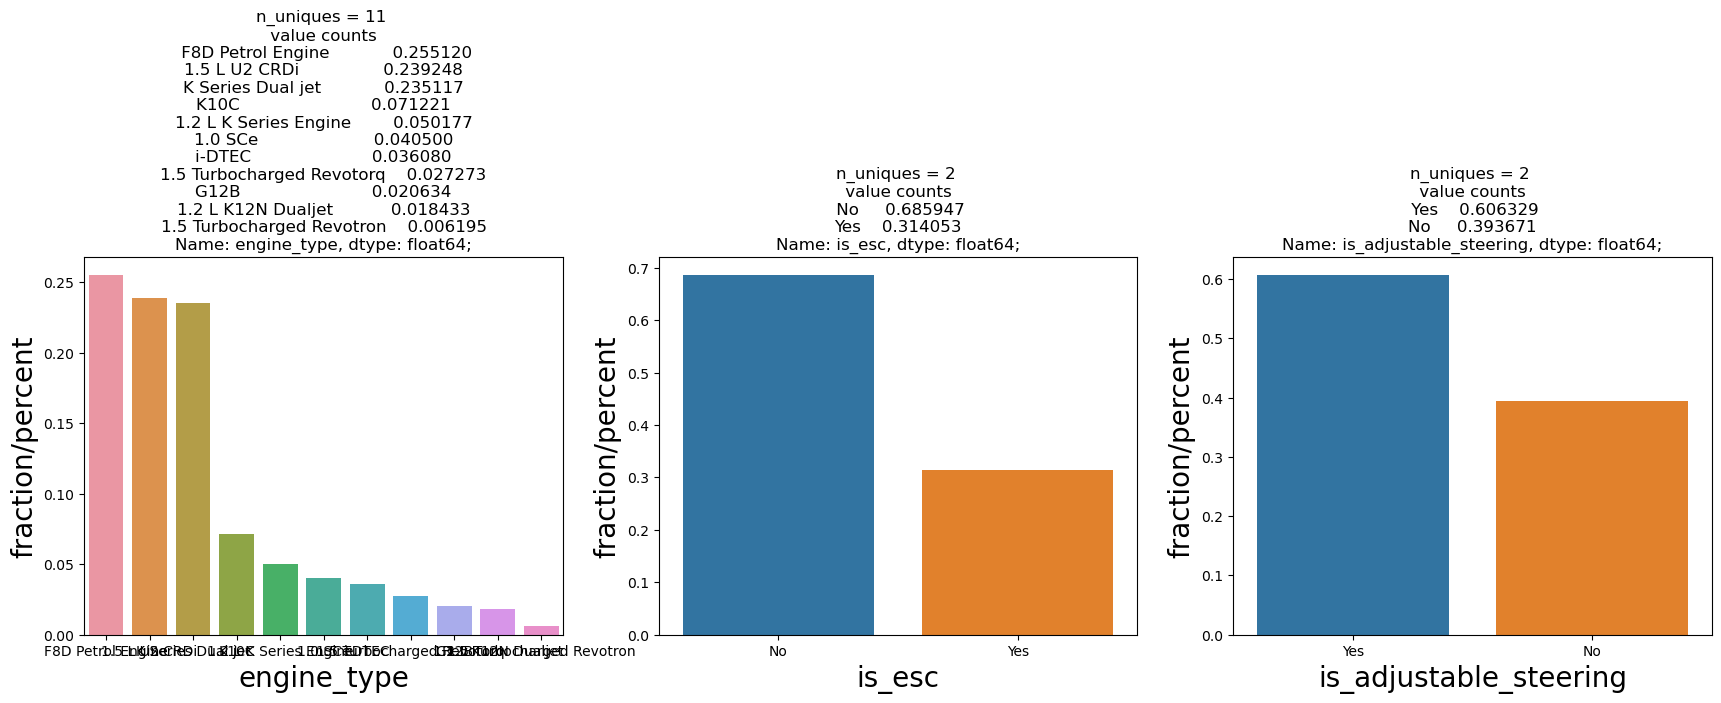

In [28]:
UVA_category(df_train, list_3)

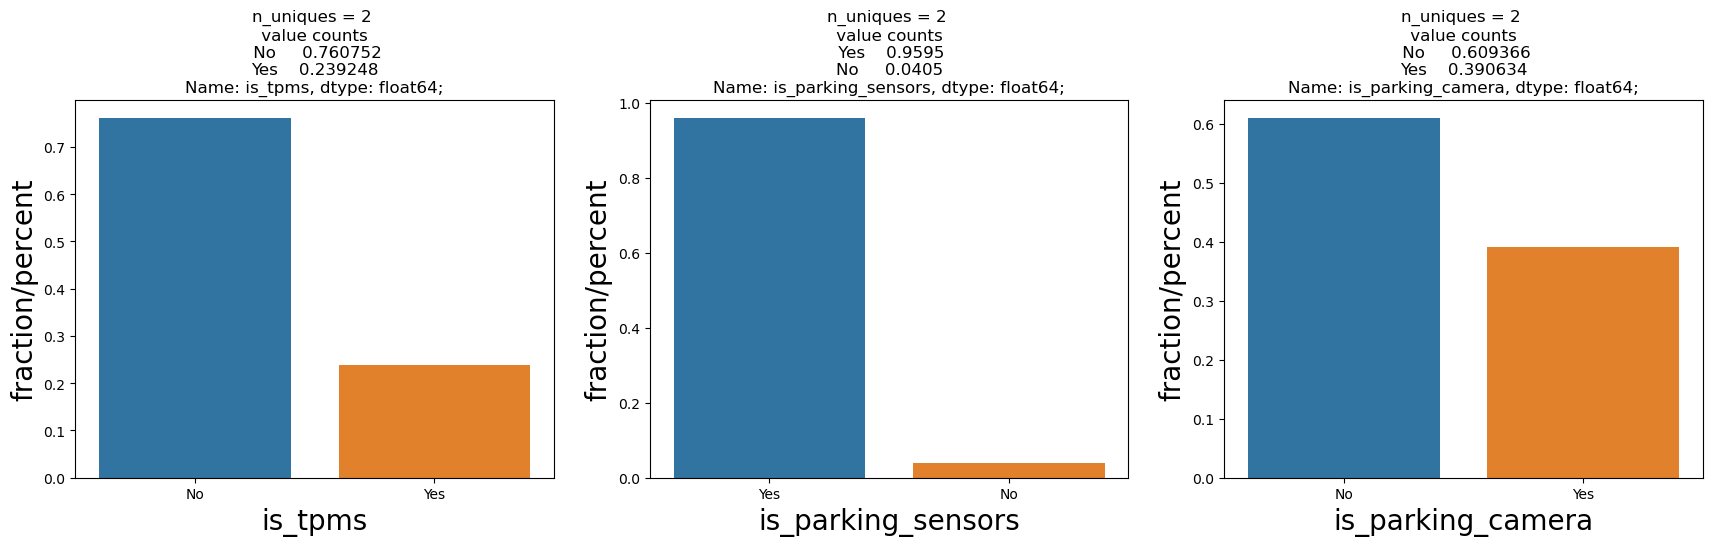

In [29]:
UVA_category(df_train, list_4)

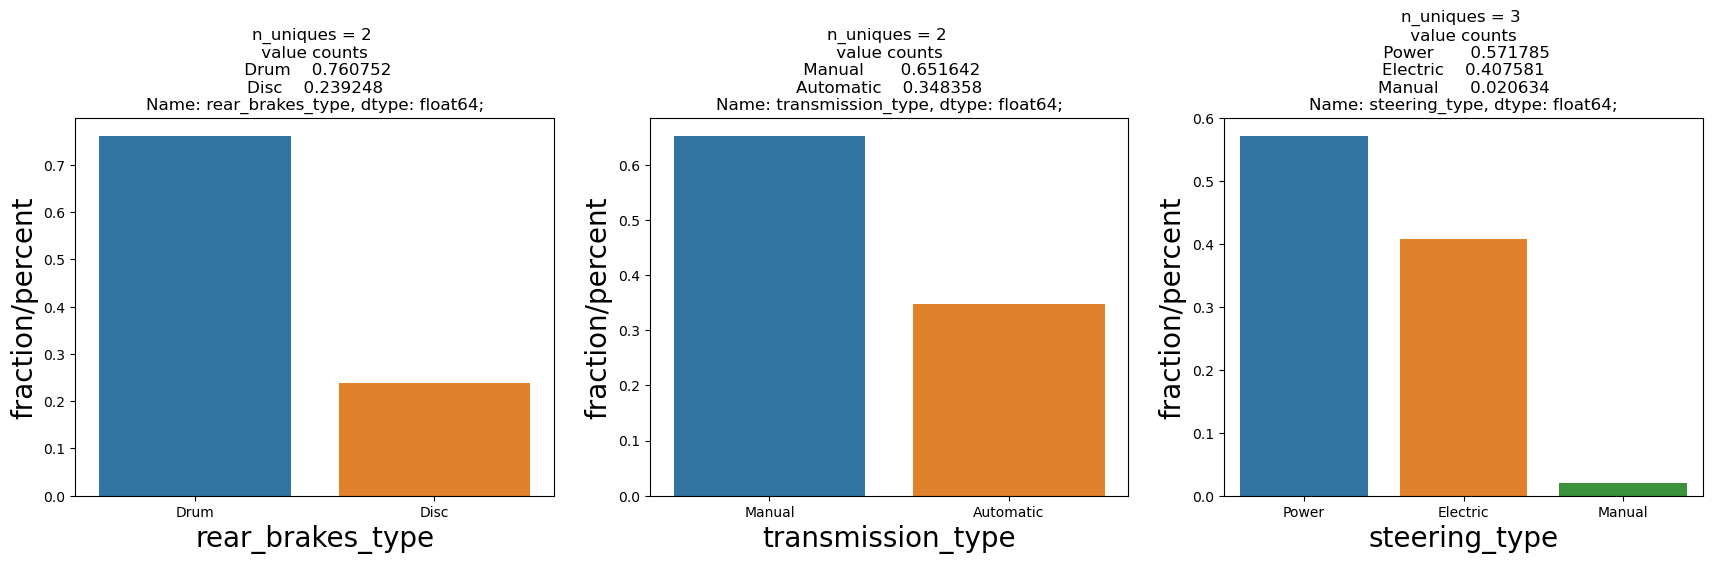

In [30]:
UVA_category(df_train, list_5)

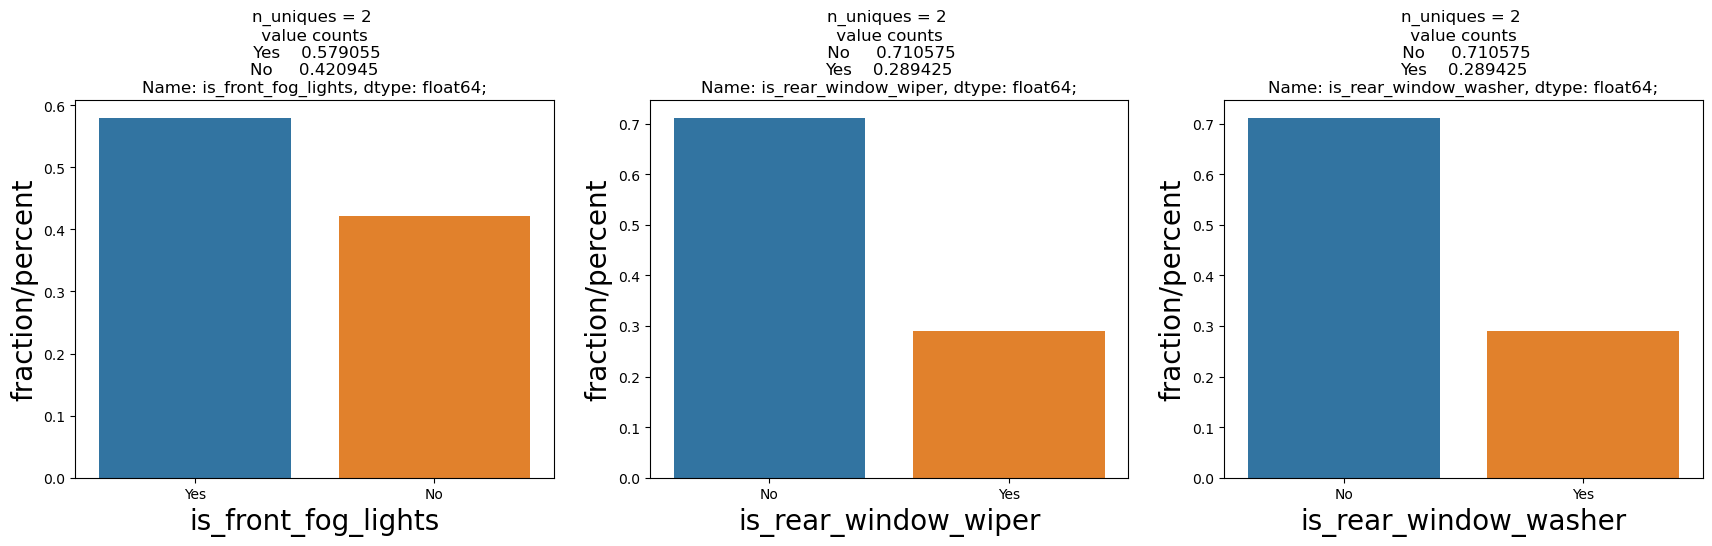

In [31]:
UVA_category(df_train, list_6)

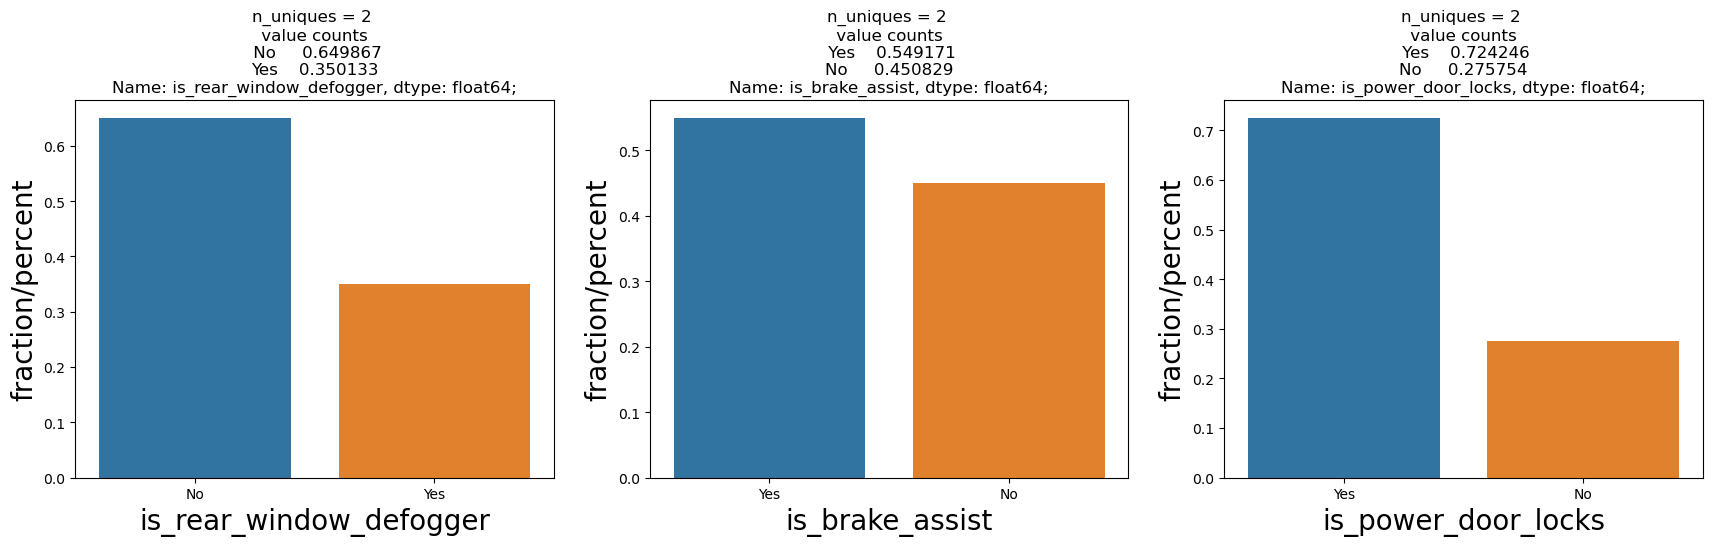

In [32]:
UVA_category(df_train, list_7)

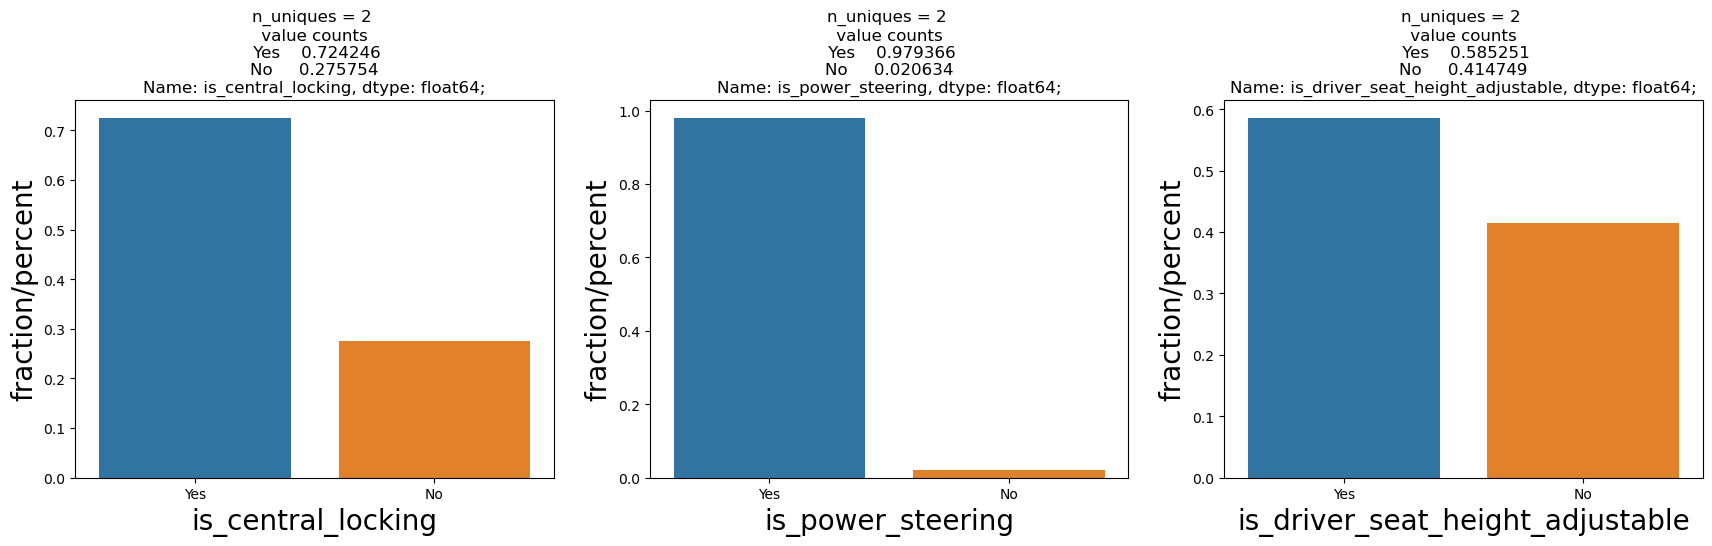

In [33]:
UVA_category(df_train, list_8)

#### *Univariate Analysis: Outlier Detection*
##### *We suspected that this dataset contains outliers let's verify that using box plots*

In [34]:
# custom function for easy outlier analysis

def UVA_outlier(data, var_group, include_outlier = True):
  '''
  Univariate_Analysis_outlier:
  takes a group of variables (INTEGER and FLOAT) and plot/print boplot and descriptives\n
  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it \n\n

  data : dataframe from which to plot from\n
  var_group : {list} type Group of Continuous variables\n
  include_outlier : {bool} whether to include outliers or not, default = True\n
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,4), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    quant25 = data[i].quantile(0.25)
    quant75 = data[i].quantile(0.75)
    IQR = quant75 - quant25
    med = data[i].median()
    whis_low = quant25-(1.5*IQR)
    whis_high = quant75+(1.5*IQR)

    # Calculating Number of Outliers
    outlier_high = len(data[i][data[i]>whis_high])
    outlier_low = len(data[i][data[i]<whis_low])

    if include_outlier == True:
      #Plotting the variable with every information
      plt.subplot(1,size,j+1)
      sns.boxplot(data[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('With Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))
      
    else:
      # replacing outliers with max/min whisker
      data2 = data[var_group][:]
      data2[i][data2[i]>whis_high] = whis_high+1
      data2[i][data2[i]<whis_low] = whis_low-1
      
      # plotting without outliers
      plt.subplot(1,size,j+1)
      sns.boxplot(data2[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('Without Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))

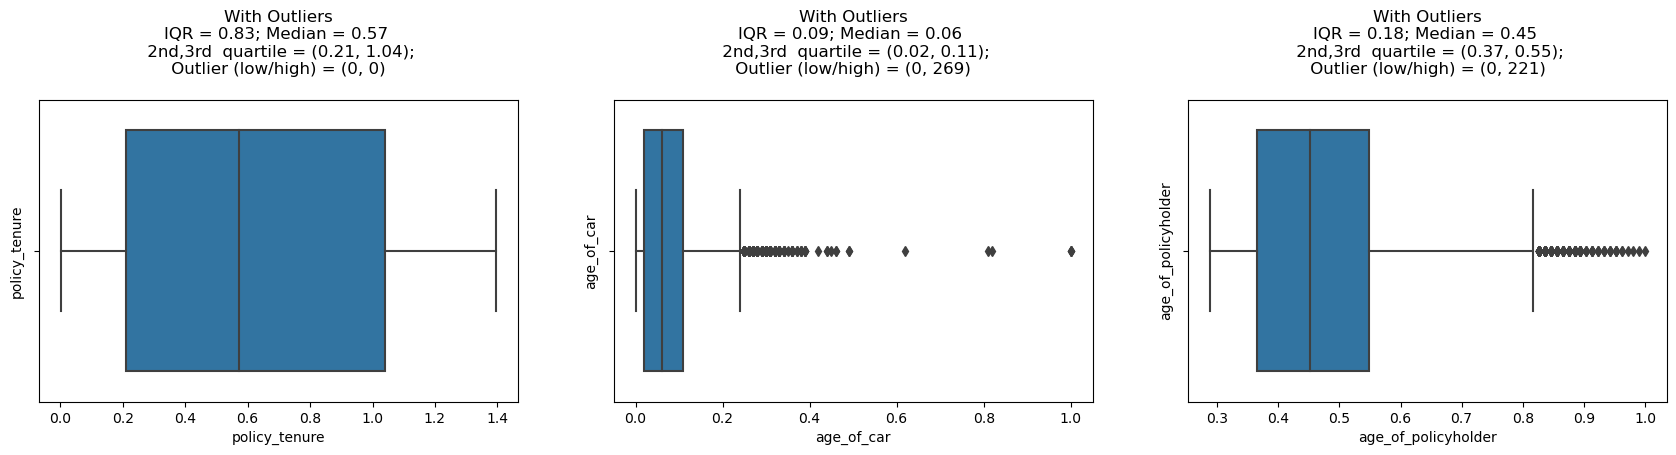

In [35]:
UVA_outlier(df_train, age_variables)


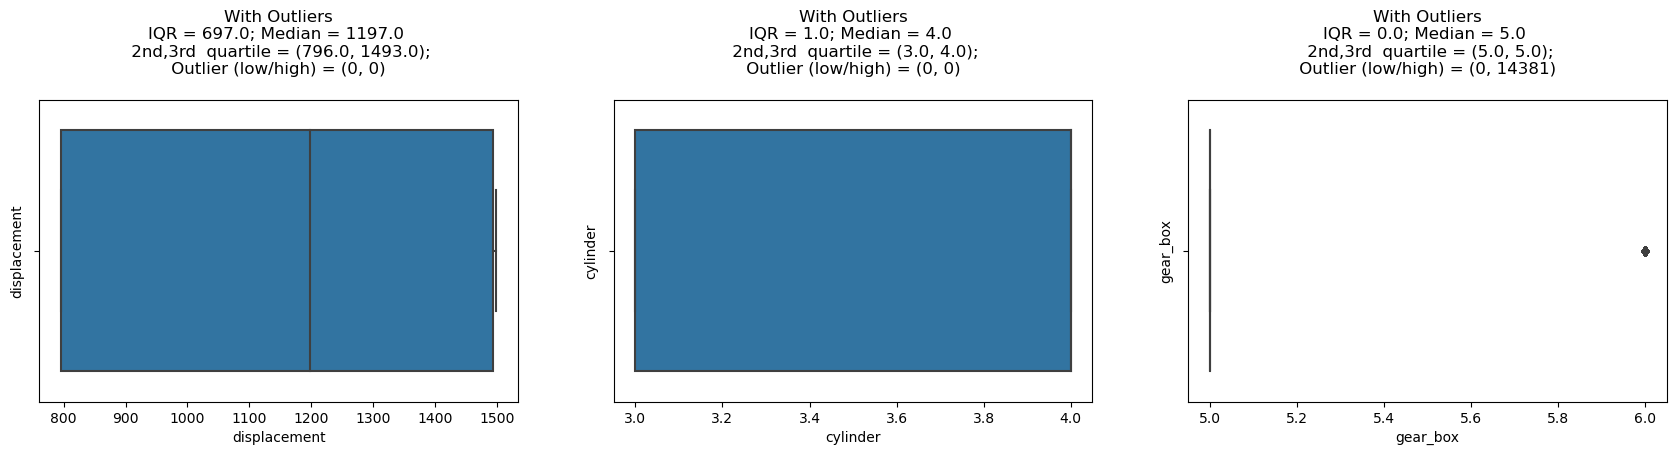

In [36]:
UVA_outlier(df_train, car_variables)


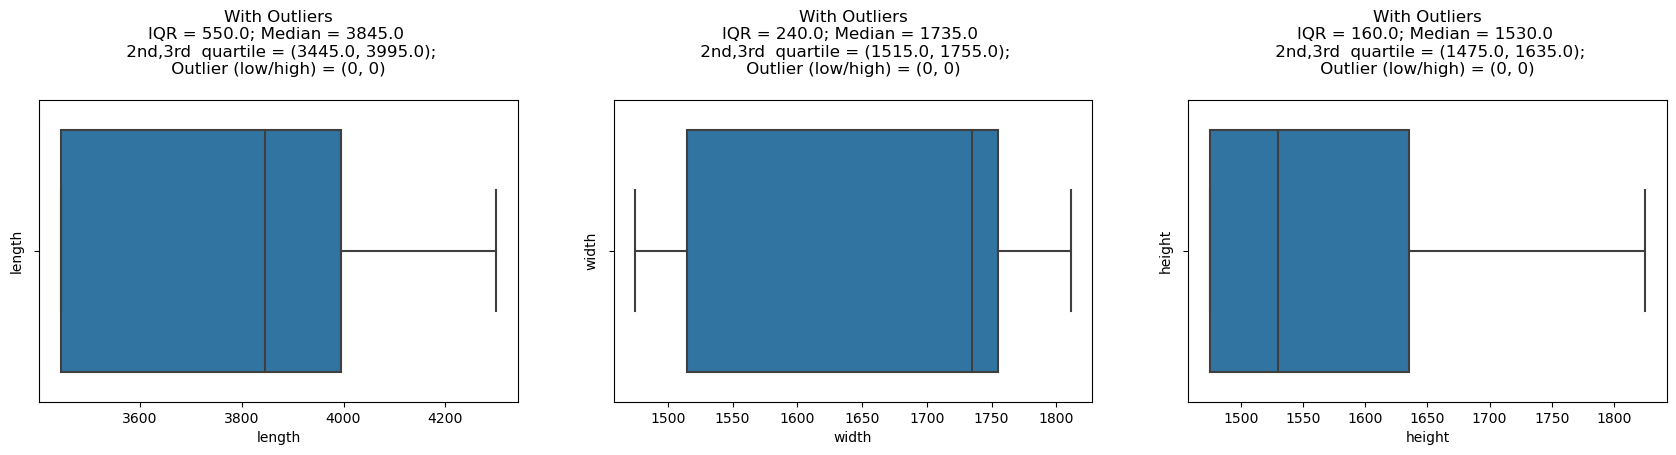

In [37]:
UVA_outlier(df_train, car_variables1)


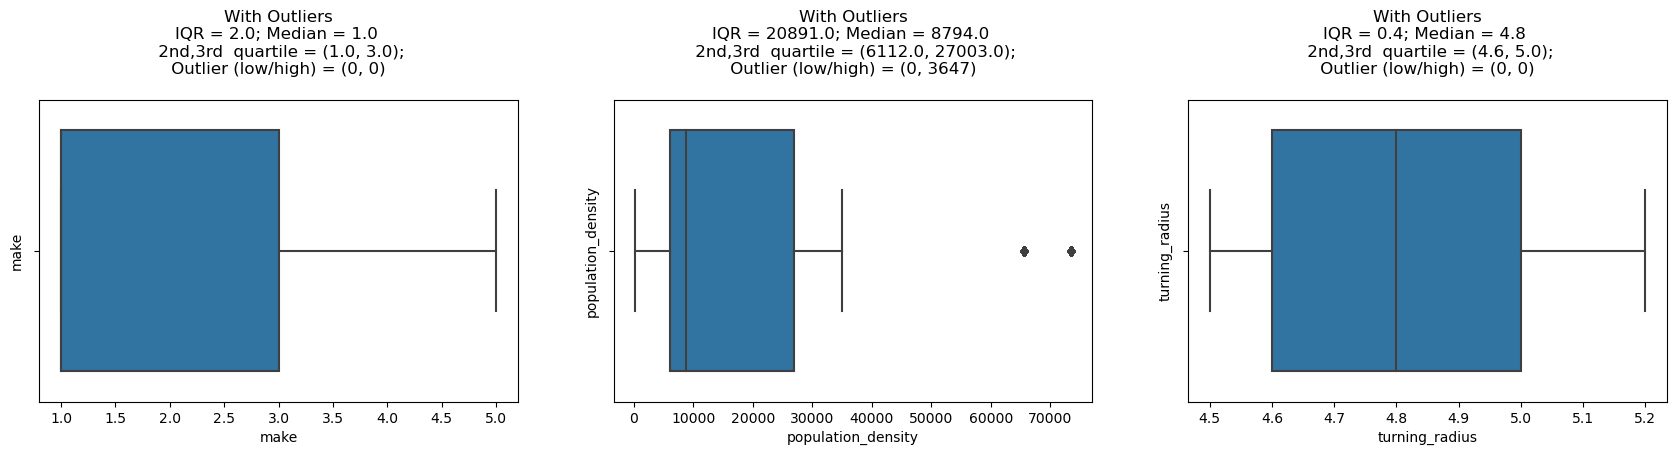

In [38]:
UVA_outlier(df_train, car_variables2)


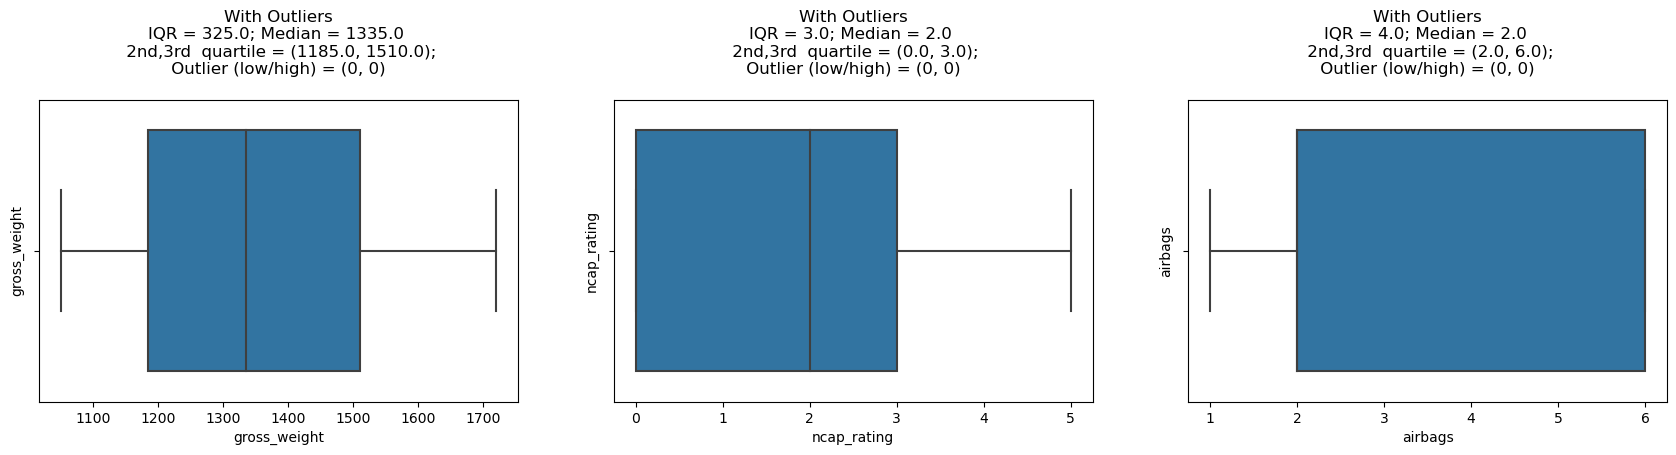

In [39]:
UVA_outlier(df_train, car_variables3)

## Bivariate Analysis

#### *Bivariate Analysis : Numerical-Numerical*
#### *Correlation Matrix*

In [40]:
df_train.corr()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
policy_tenure,1.000000,0.166312,0.143676,-0.100307,0.086101,0.103981,0.194361,0.191185,0.095305,0.166426,0.190869,0.213228,0.119055,0.141027,0.173280,0.078747
age_of_car,0.166312,1.000000,-0.035427,-0.062255,0.188122,0.209073,0.393208,0.379522,0.201579,0.332716,0.383177,0.414104,0.259156,0.302127,0.348853,-0.028172
age_of_policyholder,0.143676,-0.035427,1.000000,0.009669,-0.031989,-0.008041,-0.023764,0.004183,-0.003115,-0.016764,-0.020138,-0.006135,-0.053930,-0.007758,-0.031628,0.022435
population_density,-0.100307,-0.062255,0.009669,1.000000,-0.035125,-0.060359,-0.090983,-0.091591,-0.056640,-0.077501,-0.091968,-0.098156,-0.065583,-0.077816,-0.071150,-0.017808
make,0.086101,0.188122,-0.031989,-0.035125,1.000000,0.501800,0.753344,0.410672,0.632807,0.753861,0.692365,0.511695,0.303274,0.481408,0.792254,-0.000456
airbags,0.103981,0.209073,-0.008041,-0.060359,0.501800,1.000000,0.661190,0.478594,0.859556,0.810820,0.809094,0.639562,0.423816,0.828988,0.341557,0.002789
displacement,0.194361,0.393208,-0.023764,-0.090983,0.753344,0.661190,1.000000,0.866231,0.692240,0.875407,0.961655,0.899302,0.554591,0.776210,0.847065,0.007678
cylinder,0.191185,0.379522,0.004183,-0.091591,0.410672,0.478594,0.866231,1.000000,0.410163,0.615806,0.805476,0.862430,0.352118,0.602978,0.598364,0.013434
gear_box,0.095305,0.201579,-0.003115,-0.056640,0.632807,0.859556,0.692240,0.410163,1.000000,0.861740,0.808975,0.601923,0.579725,0.894639,0.529688,-0.000635
turning_radius,0.166426,0.332716,-0.016764,-0.077501,0.753861,0.810820,0.875407,0.615806,0.861740,1.000000,0.944899,0.825603,0.460436,0.823097,0.779302,0.002724


- Remove height, length, width and create a new feature called volume

<Figure size 840x560 with 0 Axes>

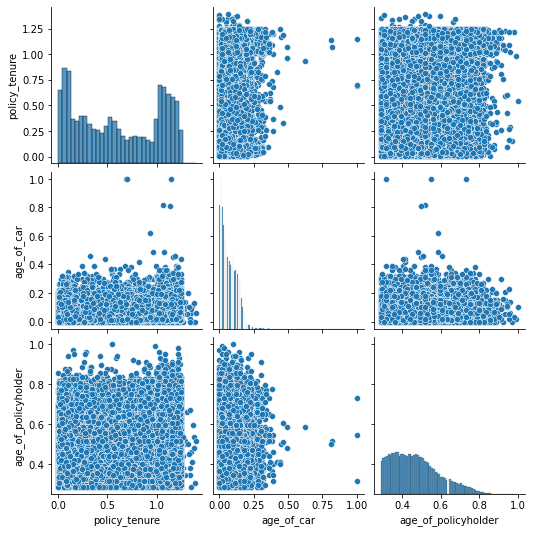

In [41]:
# scatter plot for transactional variables
plt.figure(dpi=140)
sns.pairplot(numerical_cols[age_variables])

<Figure size 840x560 with 0 Axes>

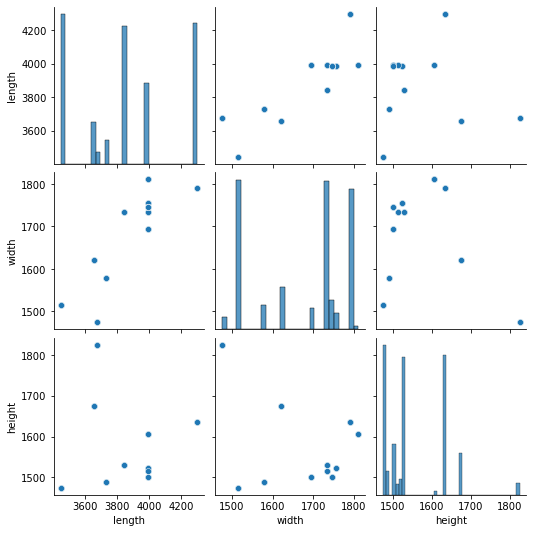

In [42]:
plt.figure(dpi=140)
sns.pairplot(numerical_cols[car_variables1])

<Figure size 840x560 with 0 Axes>

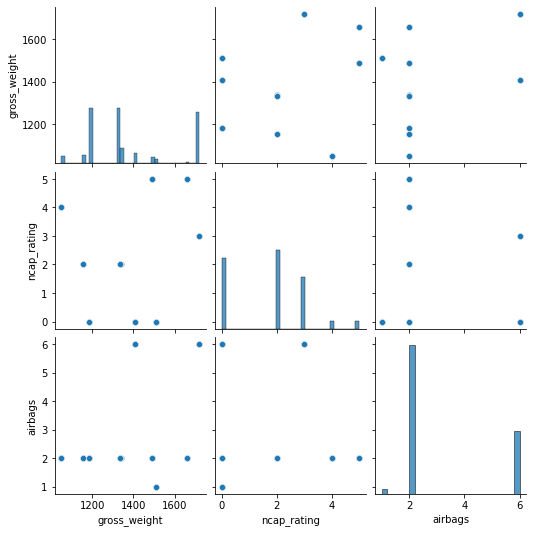

In [43]:
plt.figure(dpi=140)
sns.pairplot(numerical_cols[car_variables3])

#### *Bivariate Analysis: Continuous-Categorical variables*

- Manual transmition drivers are more likely to claim.
- Old cars are likely to claim.
- Drivers living in places with high population density are likley to claim.
- Younger drivers are more likely to claim.
- Premium hatch backs are more likely claim.
- Drivers owning cars with high maximum torque are more likely to claim.
- Drivers without ESC present are more likely to claim.
- Drivers owning cars without parking camera's are more likely to claim.
- Drivers owning cars without rear brakes will claim.
- Drivers owning cars with manual steering type are more likely to claim.
- The longer the policy term ....


In [44]:
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
    
    '''
    takes mean, standard deviation, and number of observations and returns 
    p-value calculated for 2-sampled Z-Test
    '''
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
    z = (X1 - X2)/ovr_sigma
    pval = 2*(1 - norm.cdf(abs(z)))
    return pval

In [45]:
def TwoSampT(X1, X2, sd1, sd2, n1, n2):
    
    from numpy import sqrt, abs, round
    from scipy.stats import t as t_dist
    ovr_sd = sqrt(sd1**2/n1 + sd2**2/n2)
    t = (X1 - X2)/ovr_sd
    df = n1+n2-2
    pval = 2*(1 - t_dist.cdf(abs(t),df))
    return pval
  


In [46]:
def Bivariate_cont_cat(data, cont, cat, category):
  #creating 2 samples
  x1 = data[cont][data[cat]==category][:]
  x2 = data[cont][~(data[cat]==category)][:]
  
  #calculating descriptives
  n1, n2 = x1.shape[0], x2.shape[0]
  m1, m2 = x1.mean(), x2.mean()
  std1, std2 = x1.std(), x2.mean()
  
  #calculating p-values
  t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
  z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)

  #table
  table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)

  #plotting
  plt.figure(figsize = (15,6), dpi=140)
  
  #barplot
  plt.subplot(1,2,1)
  sns.barplot([str(category),'not {}'.format(category)], [m1, m2])
  plt.ylabel('mean {}'.format(cont))
  plt.xlabel(cat)
  plt.title('t-test p-value = {} \n z-test p-value = {}\n {}'.format(t_p_val,
                                                                z_p_val,
                                                                table))

  # boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x=cat, y=cont, data=data)
  plt.title('categorical boxplot')
  

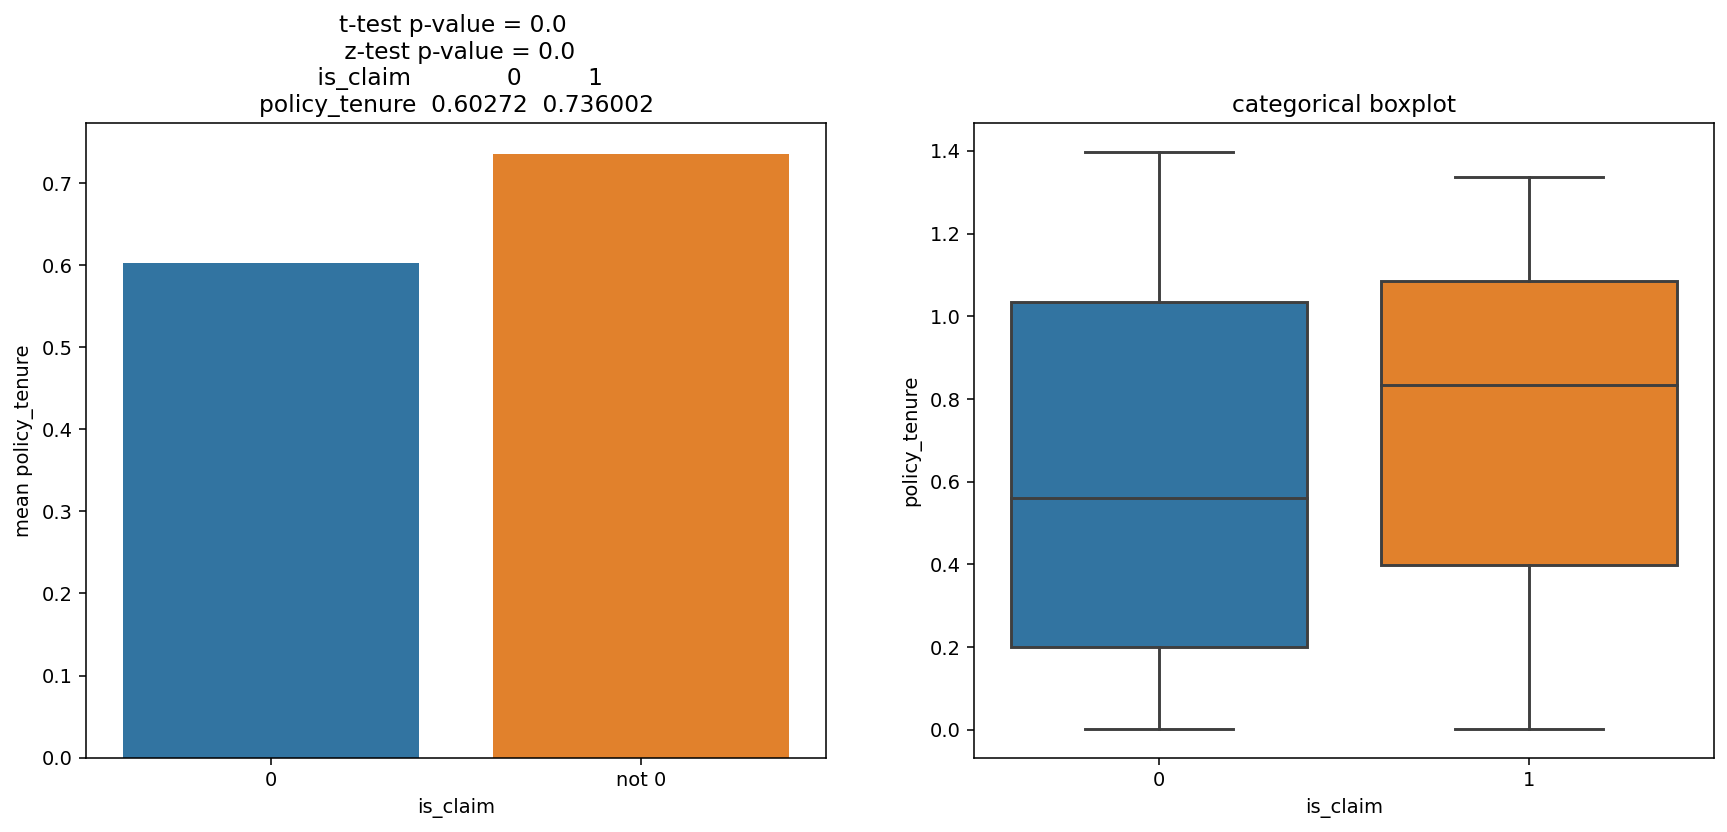

In [47]:
Bivariate_cont_cat(df_train,'policy_tenure','is_claim',0)

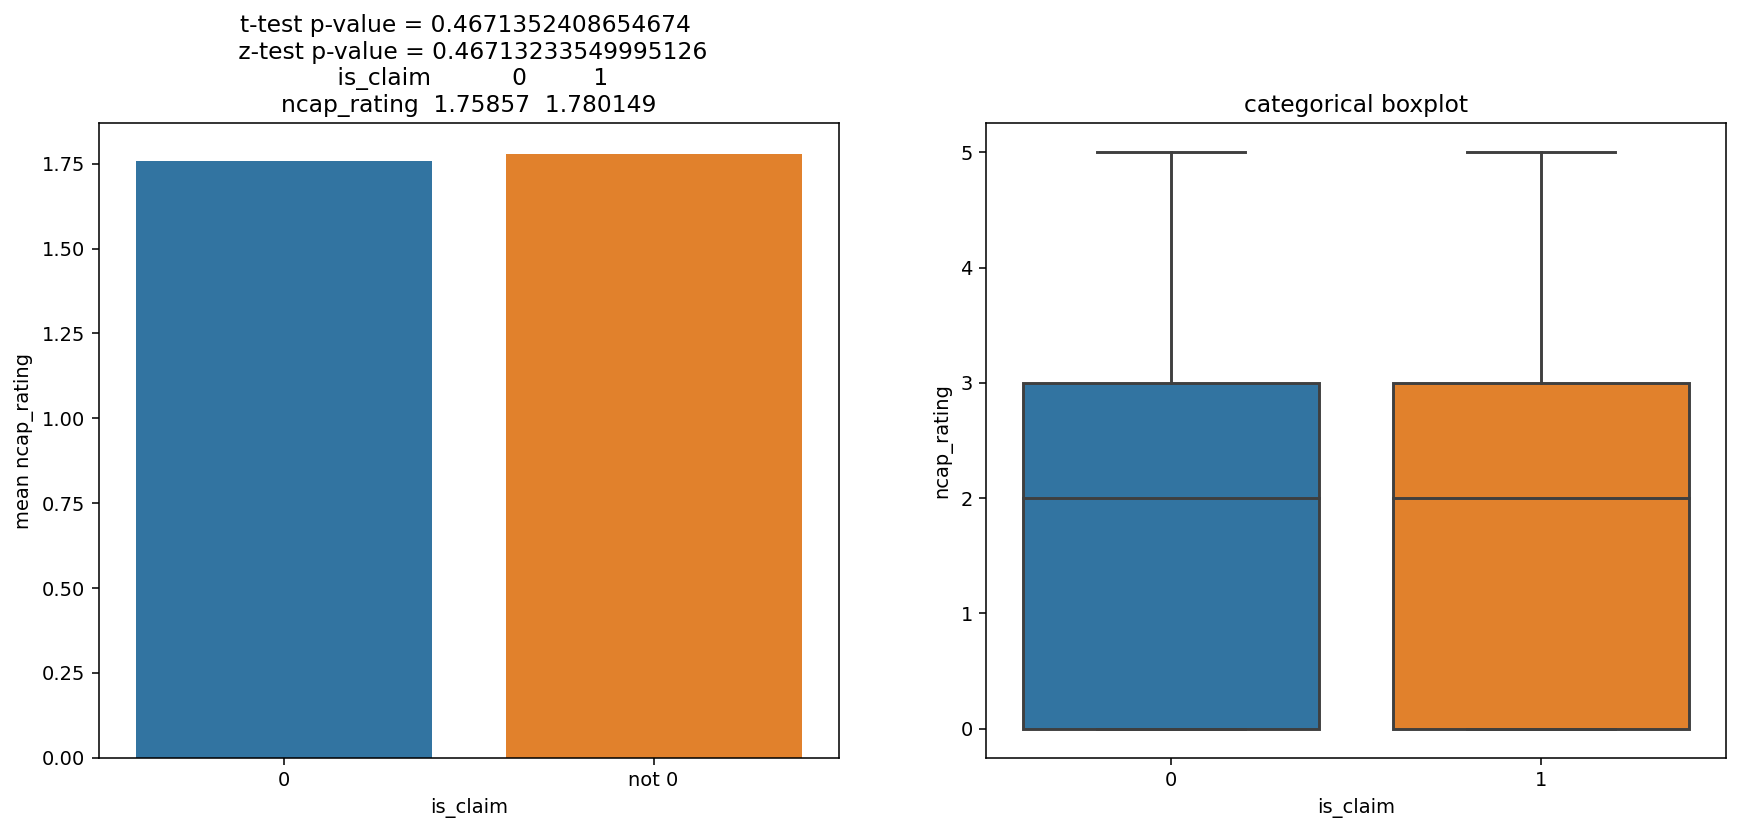

In [48]:
Bivariate_cont_cat(df_train,'ncap_rating','is_claim',0)

ValueError: Grouper for 'is_claim' not 1-dimensional

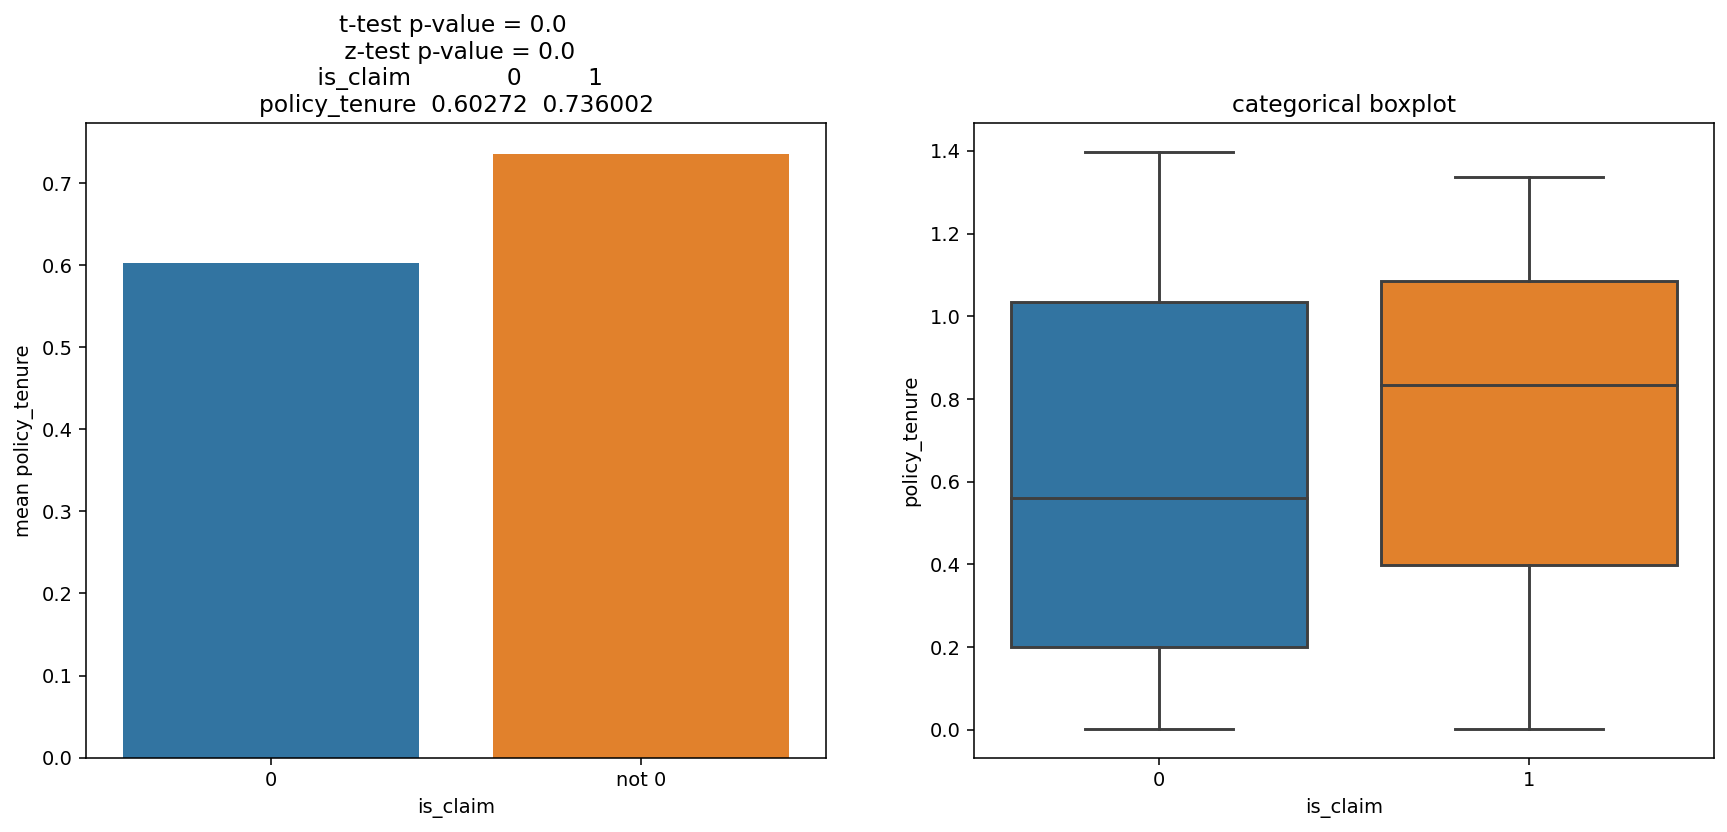

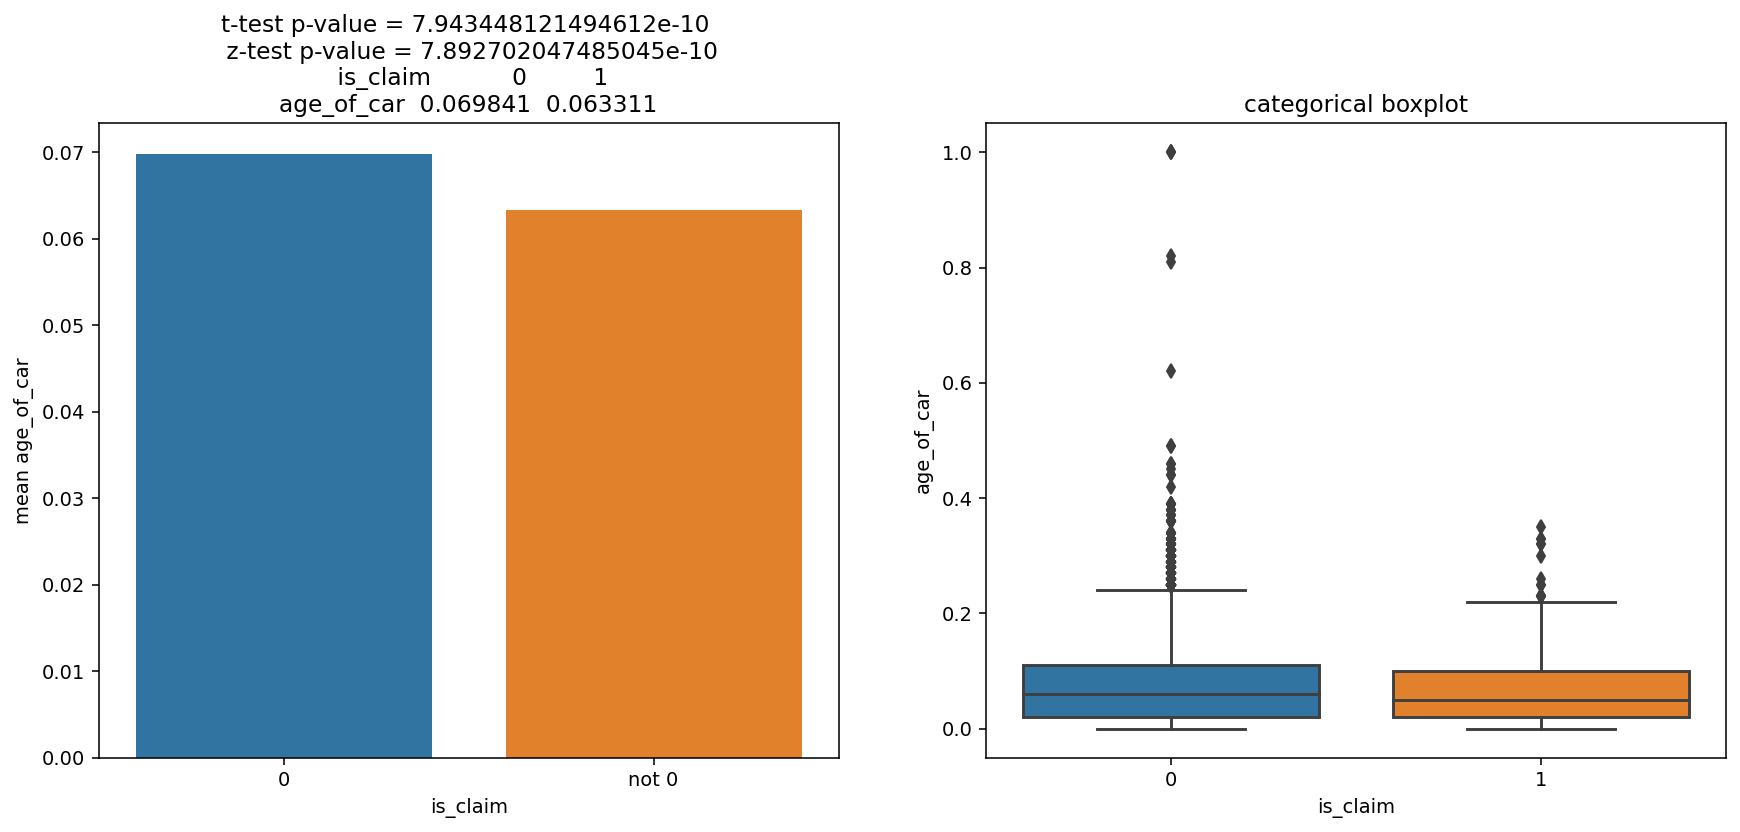

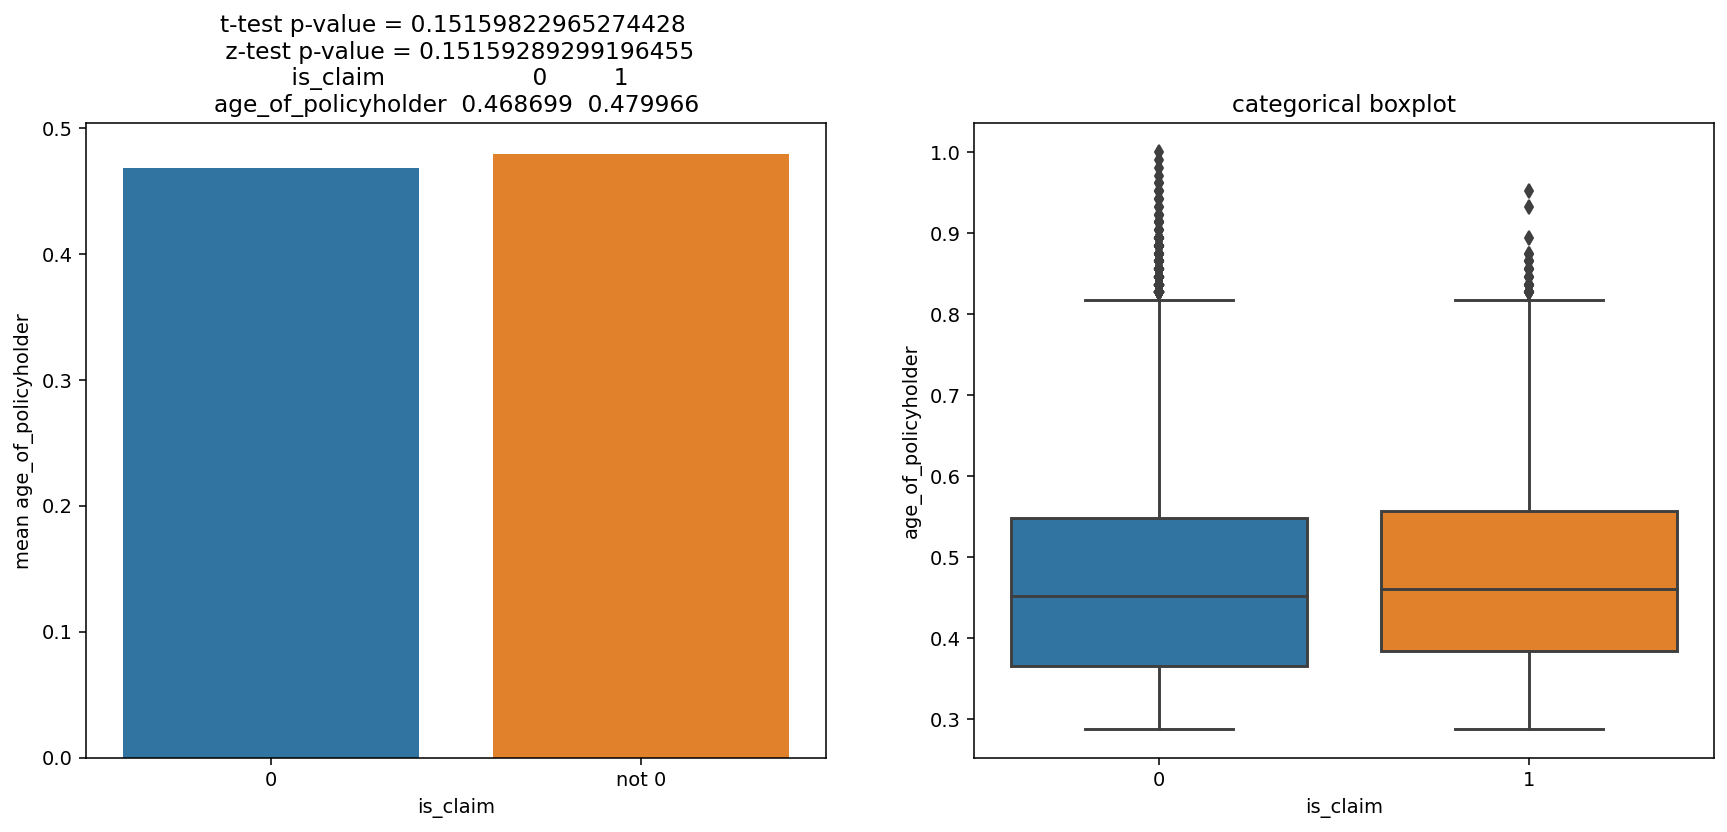

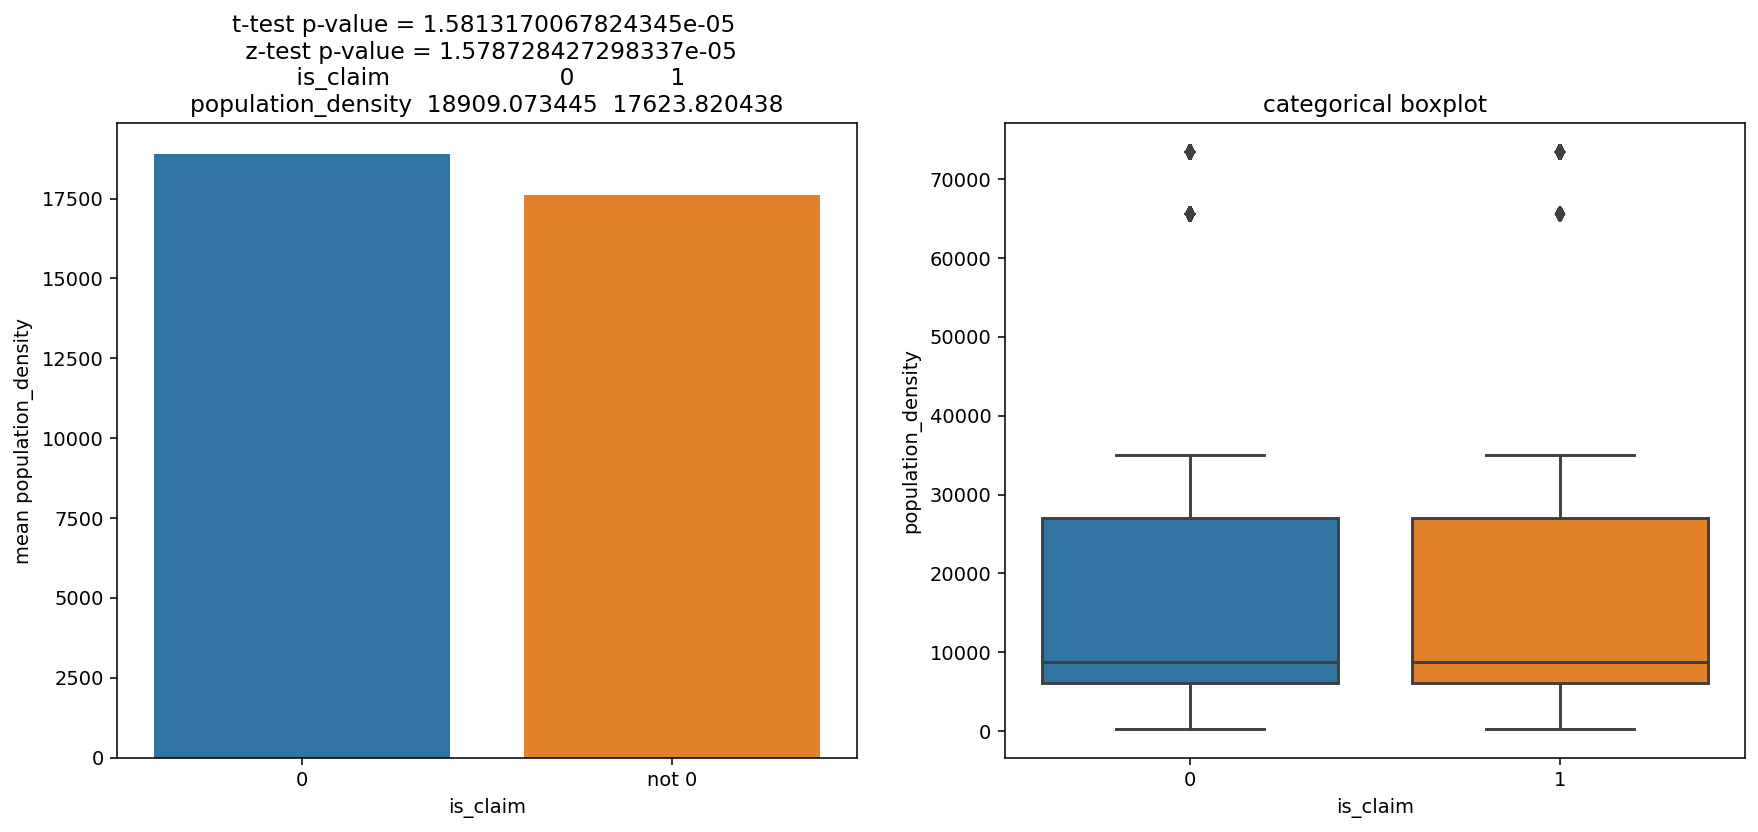

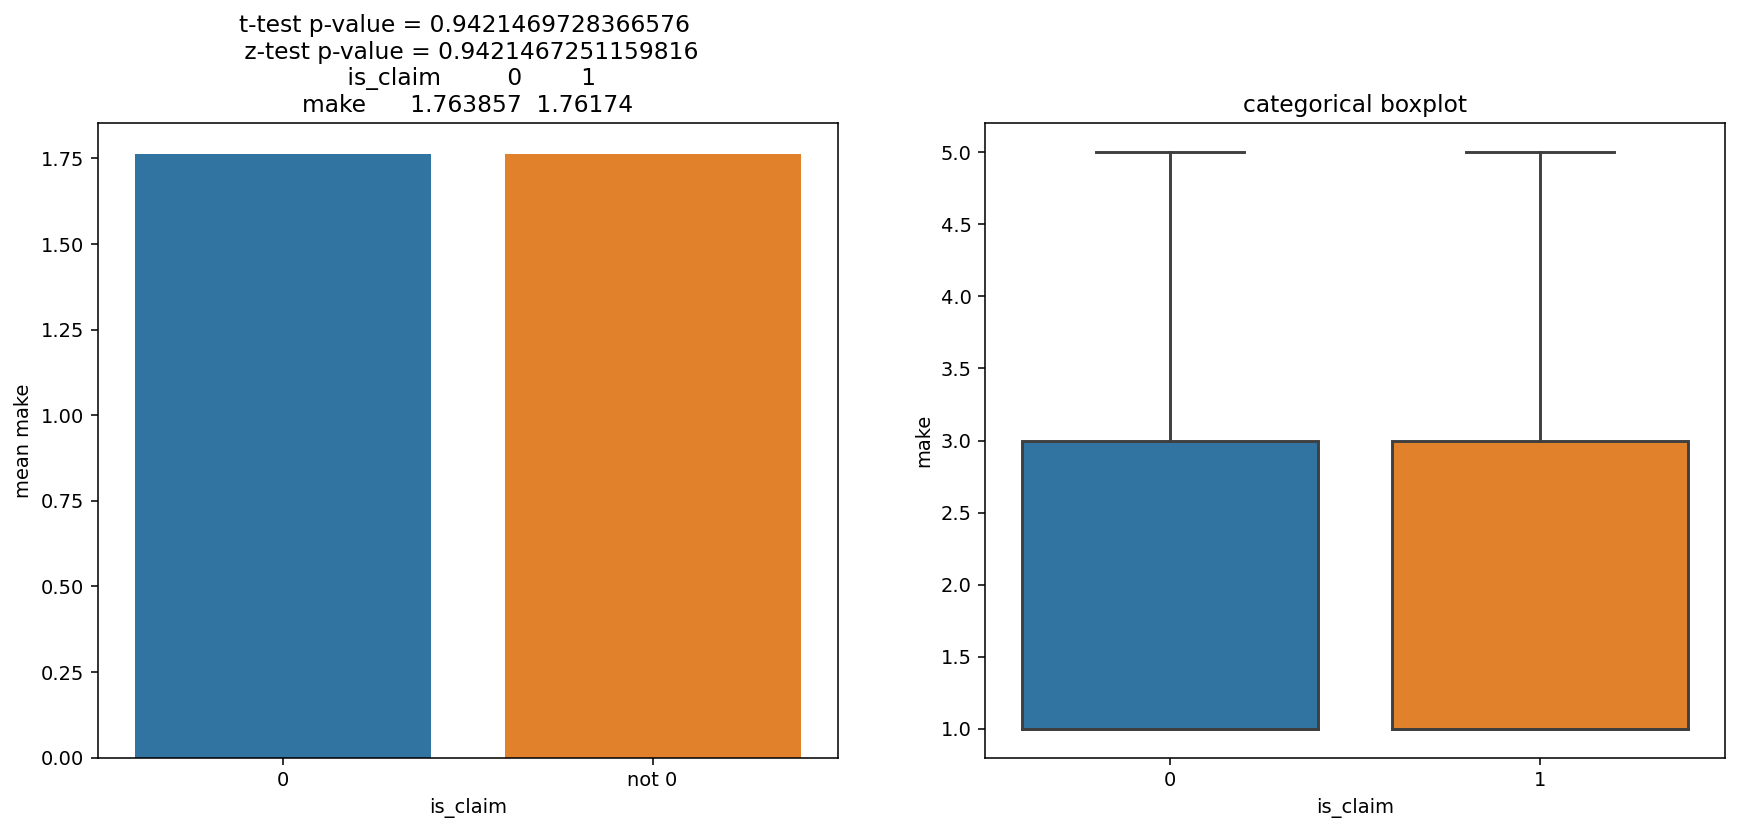

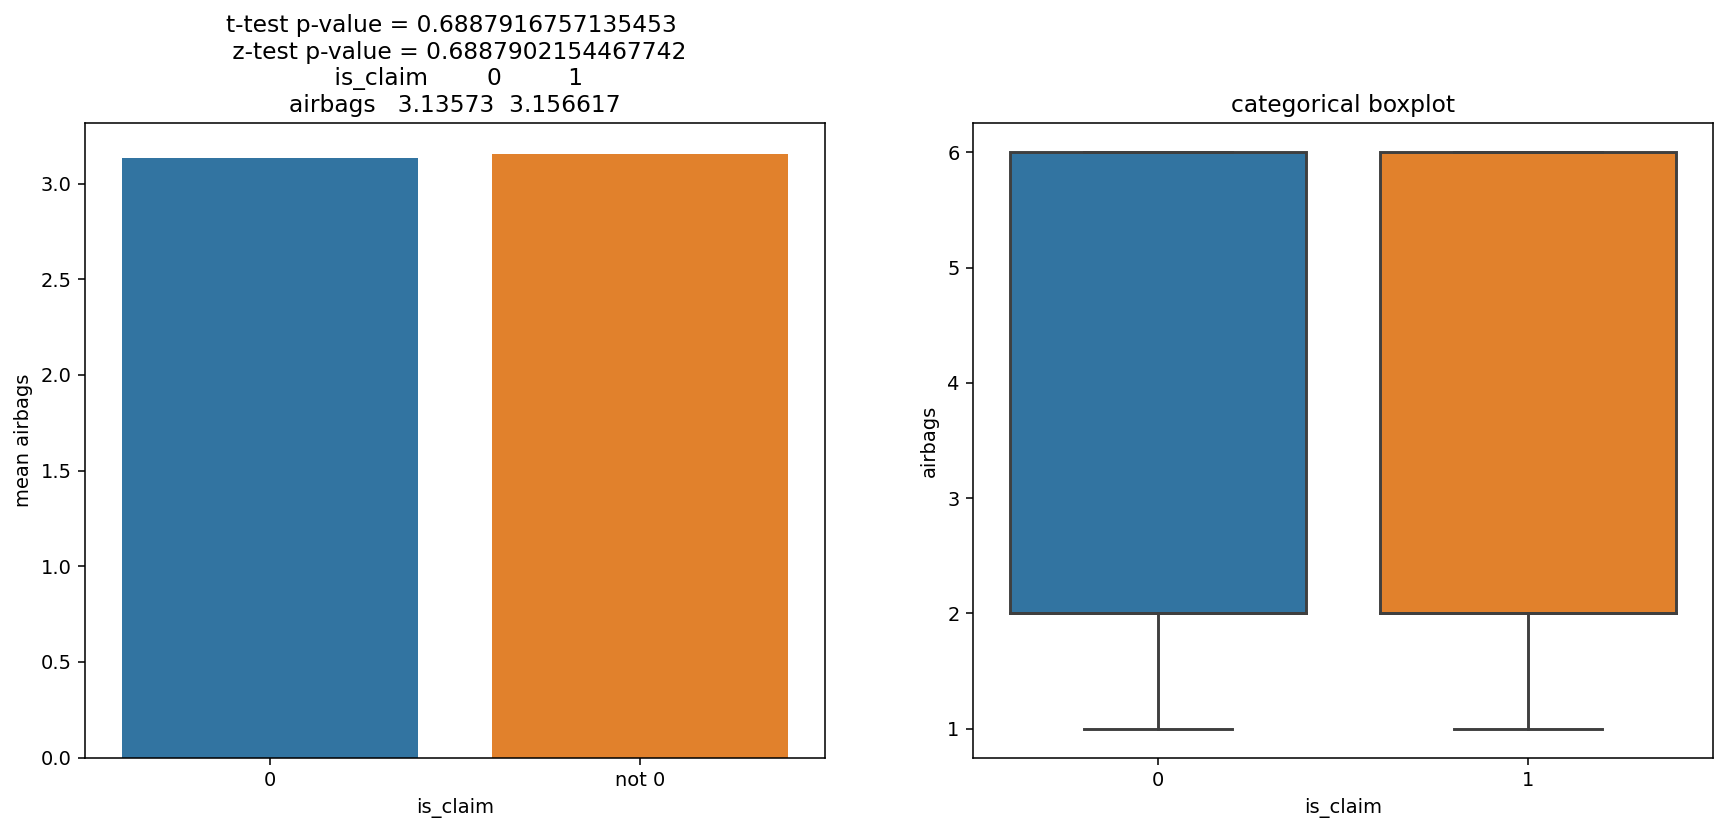

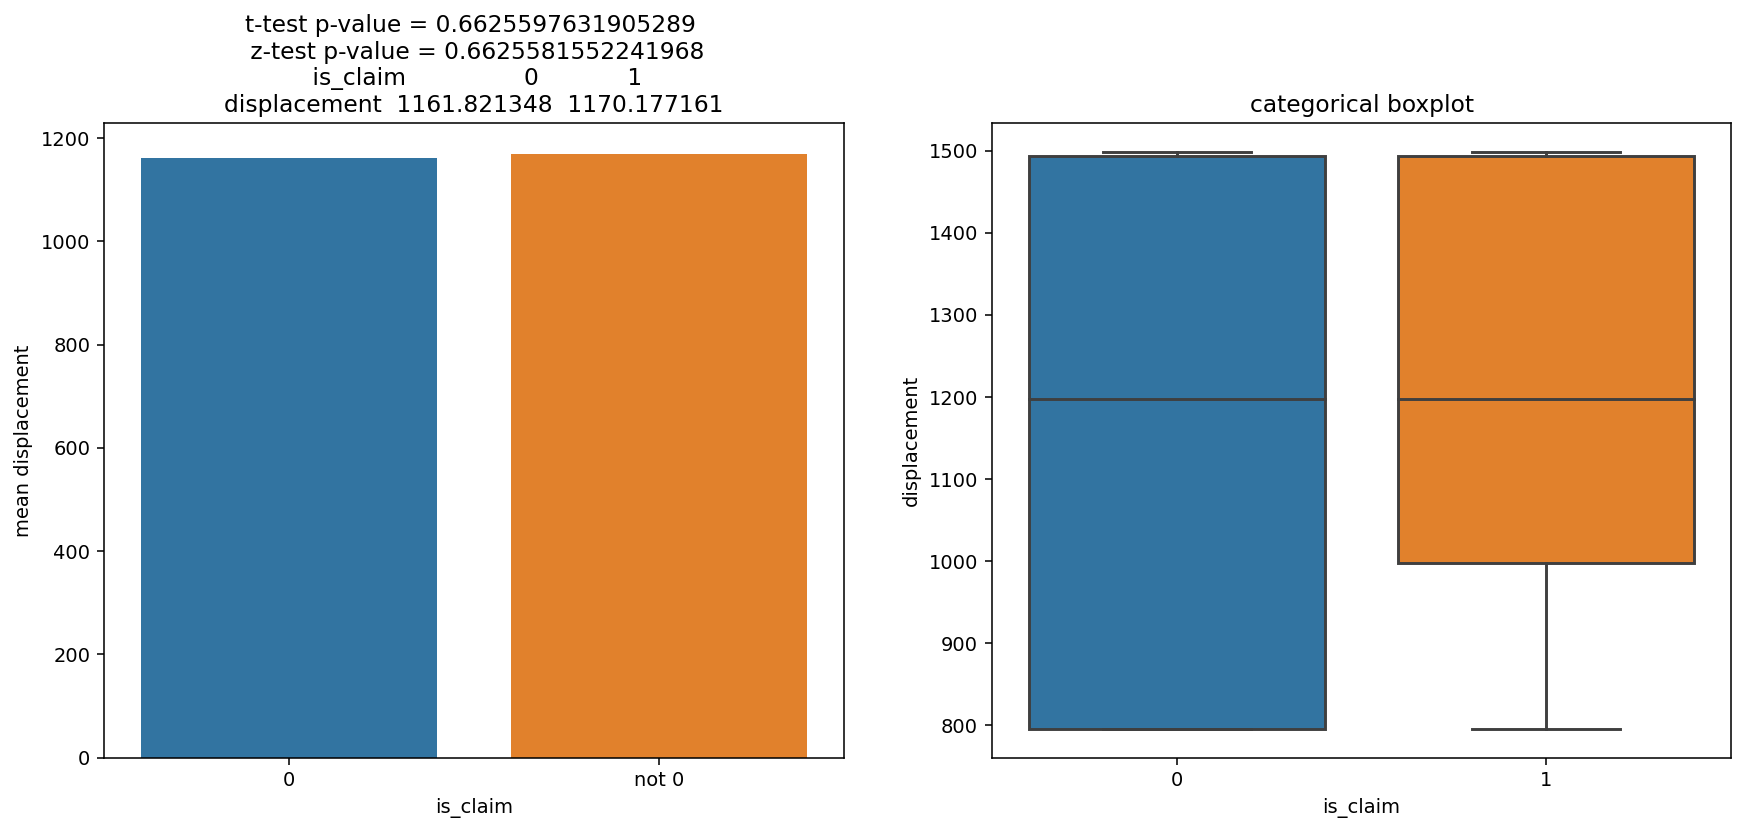

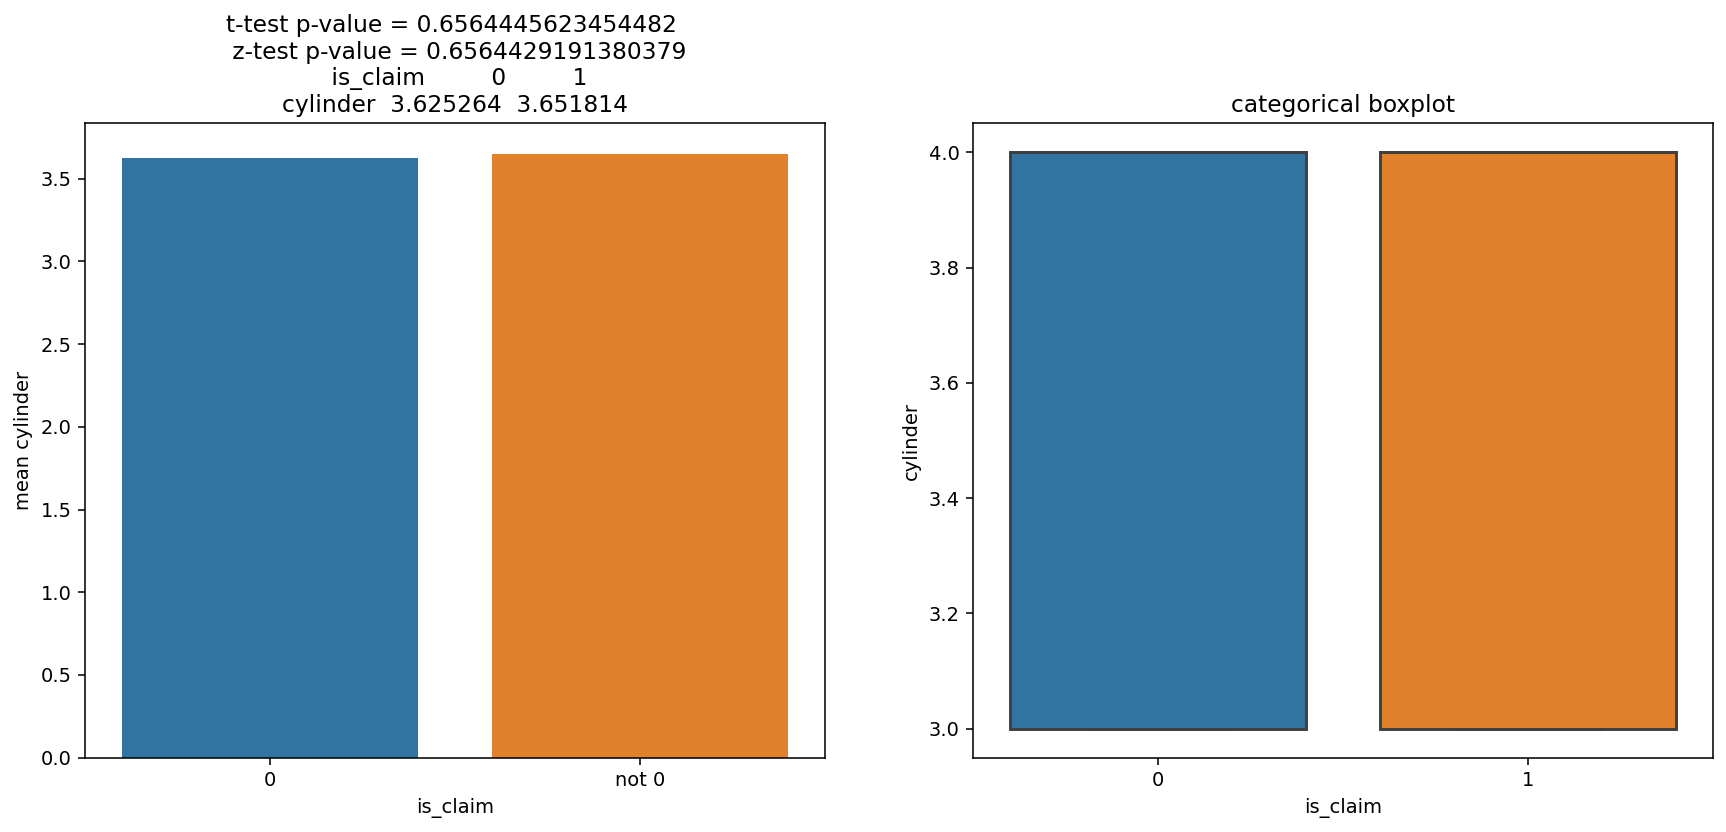

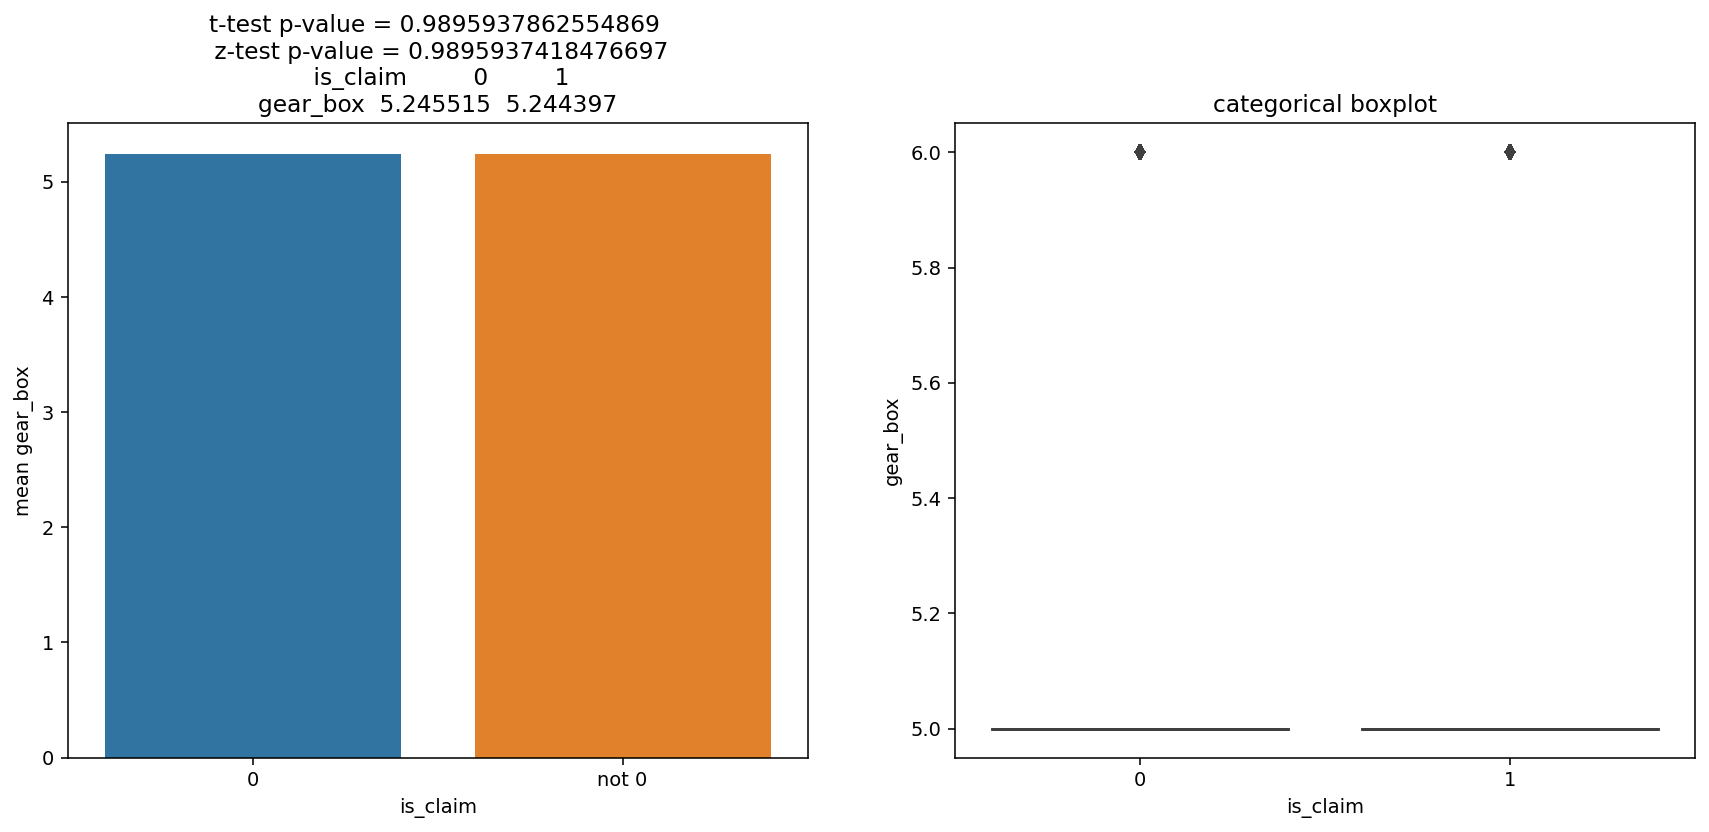

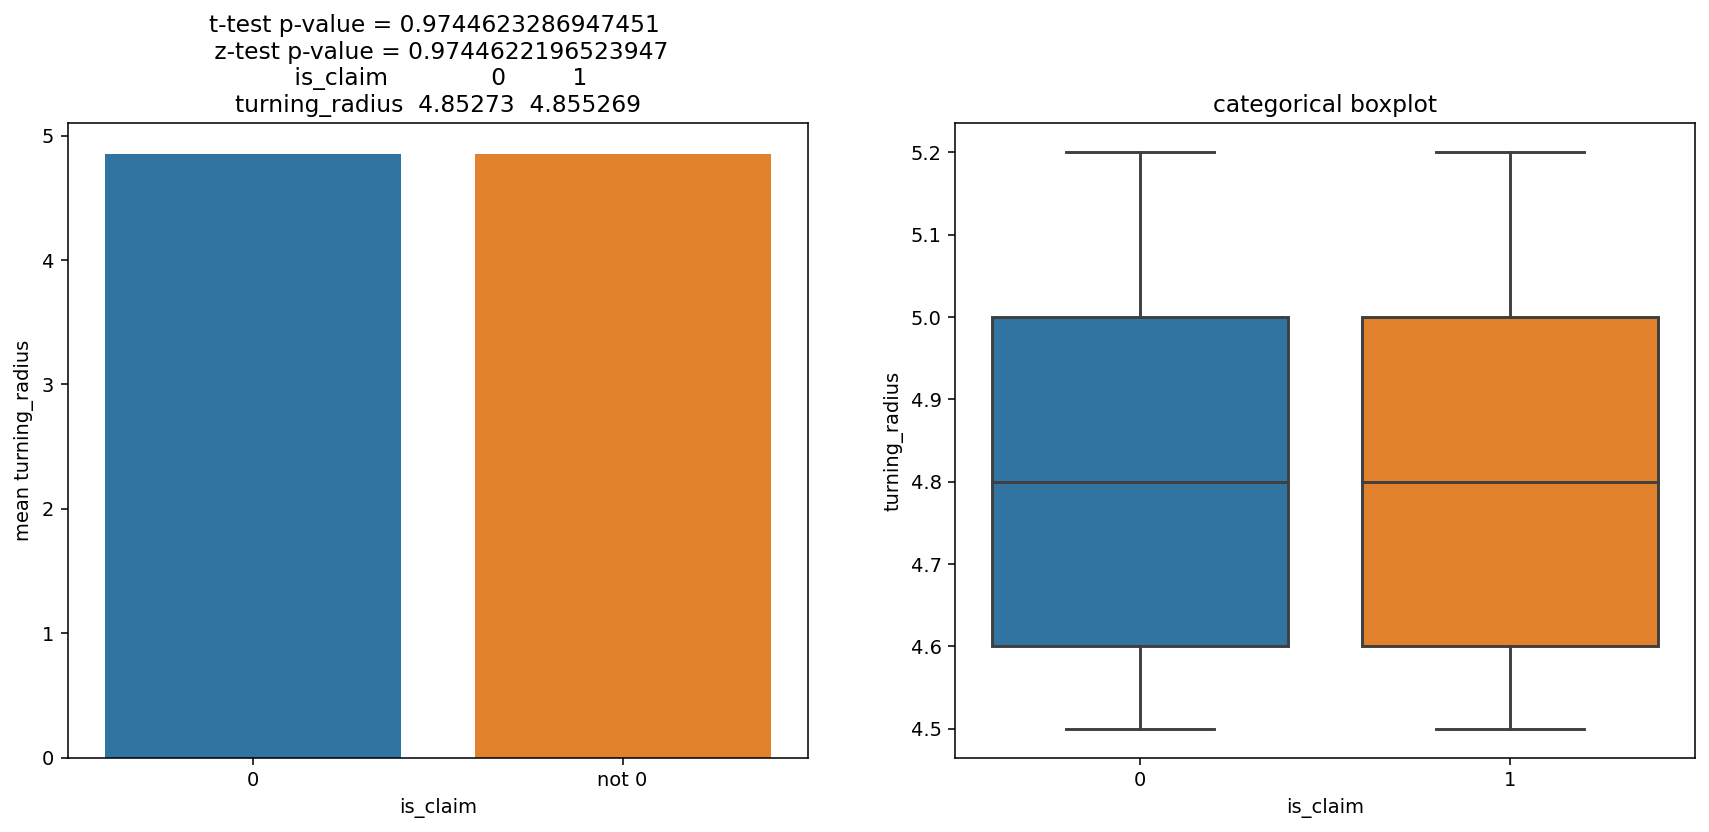

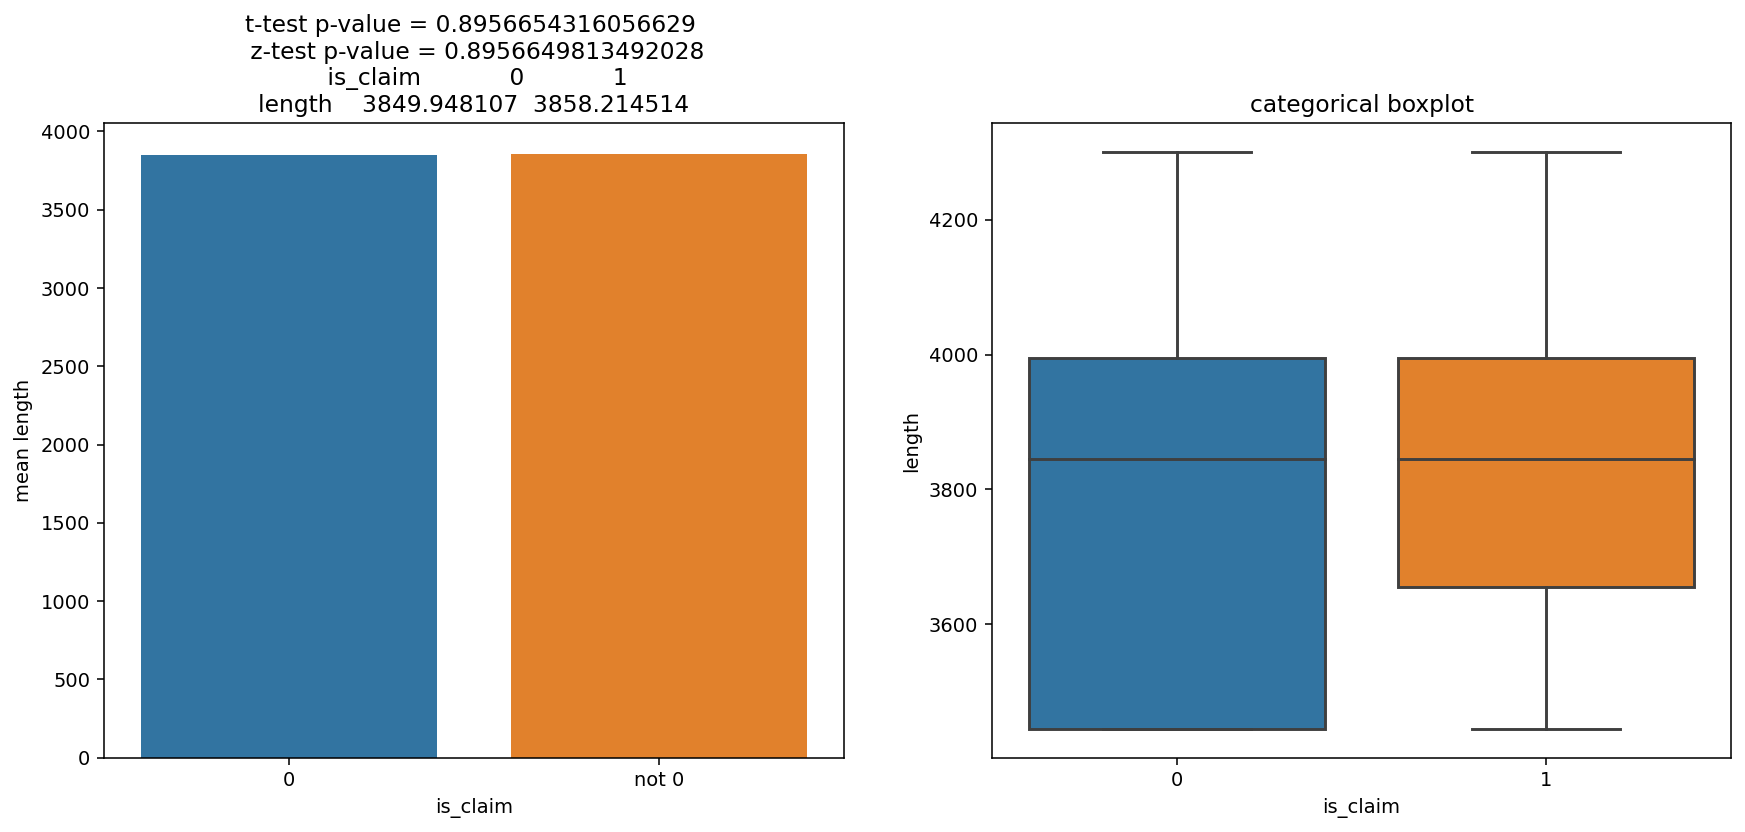

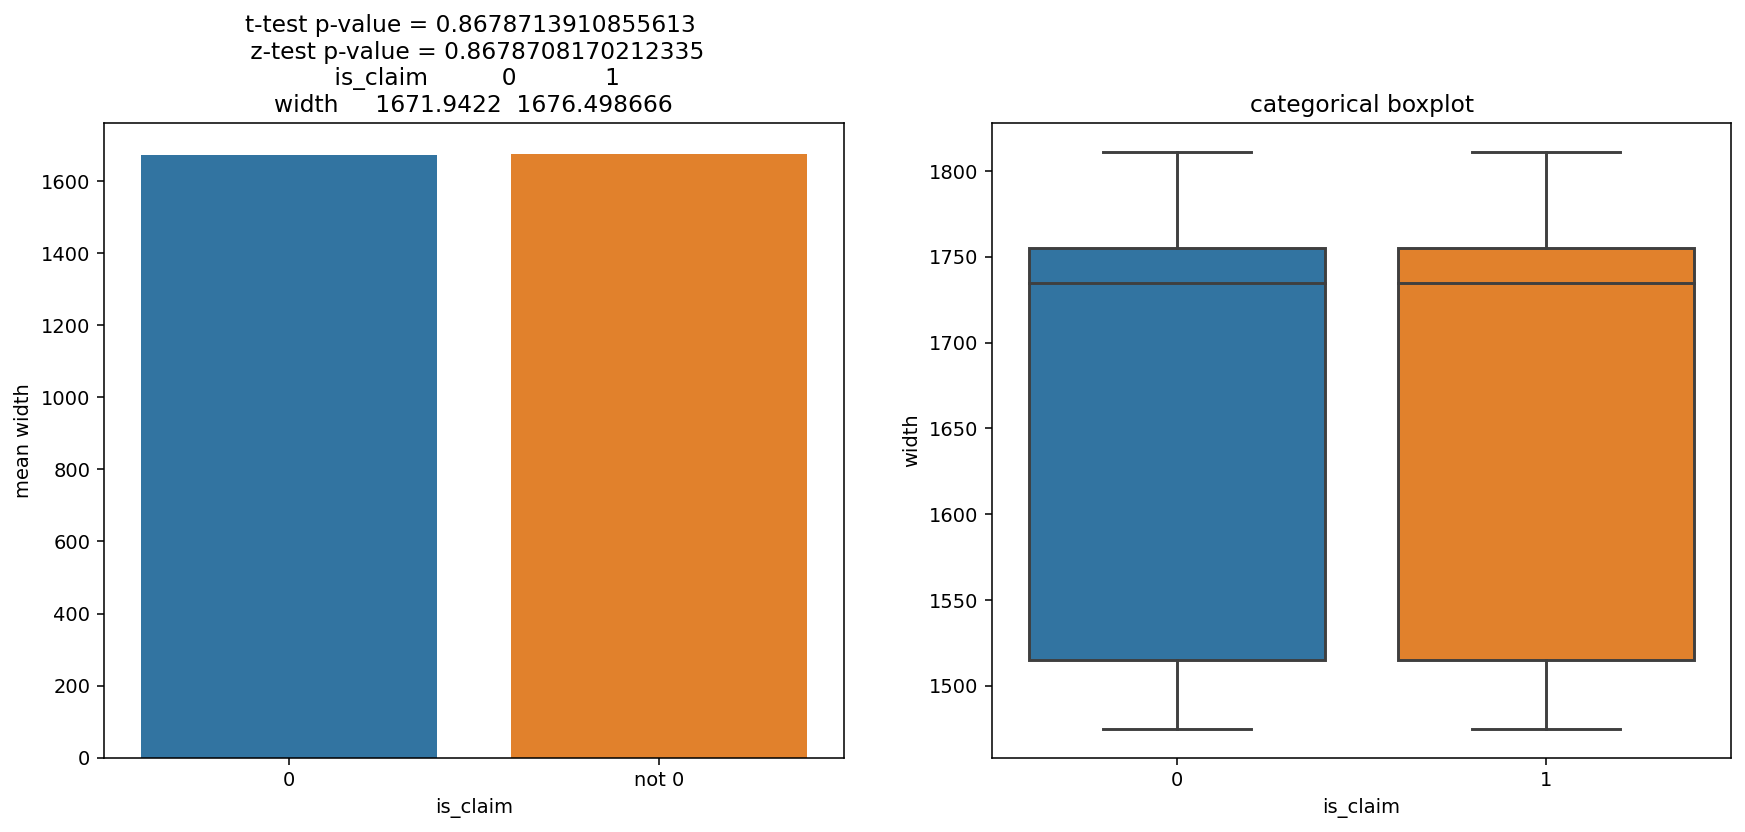

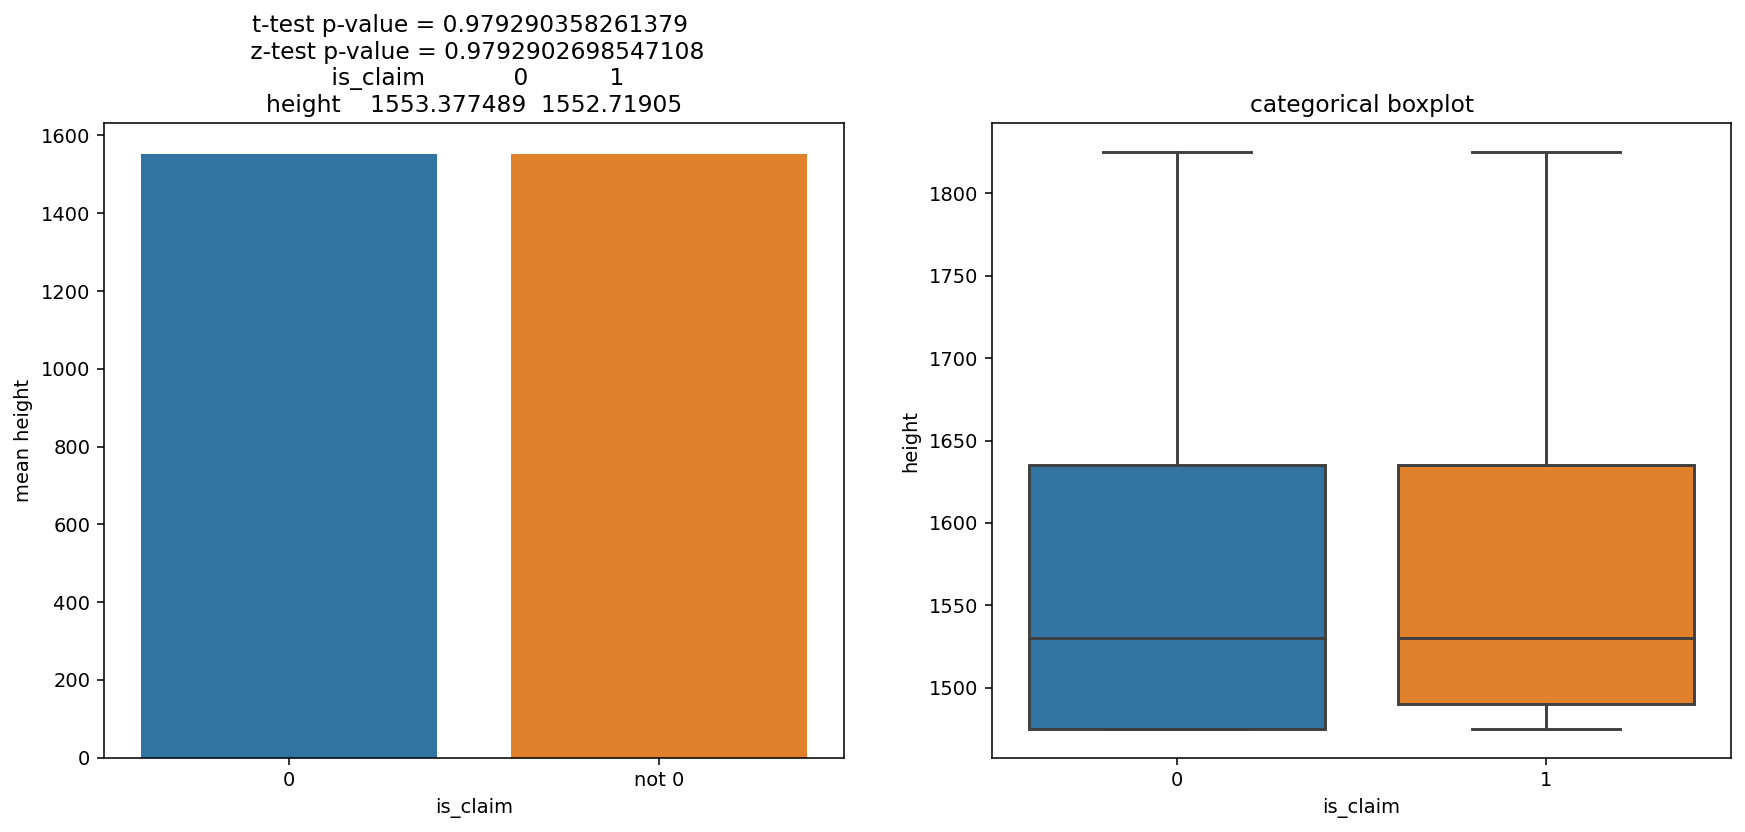

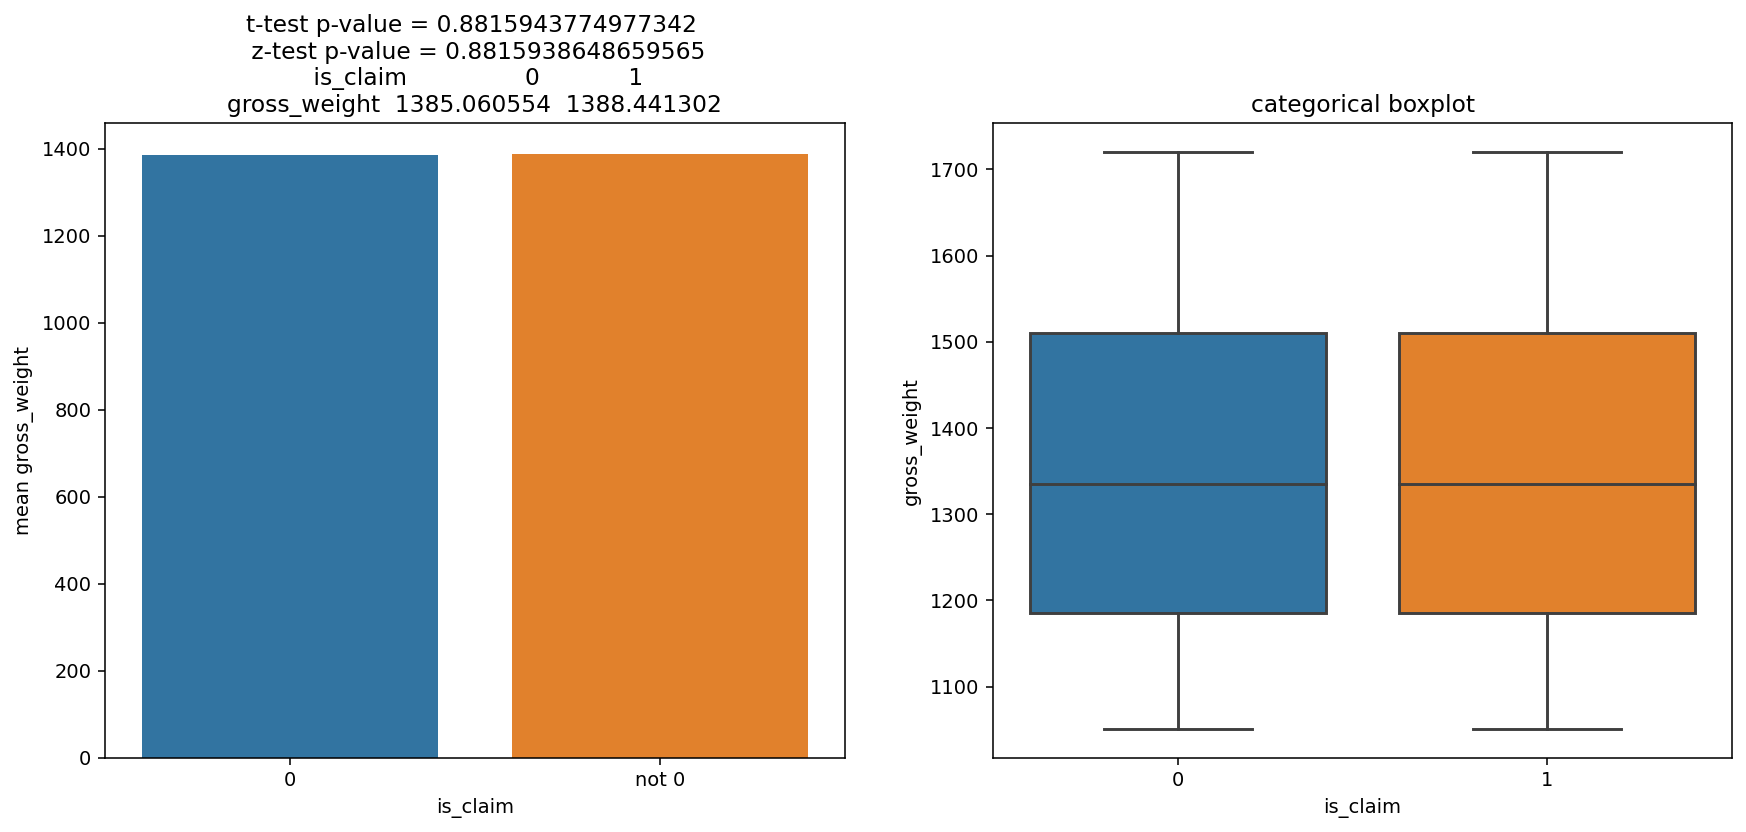

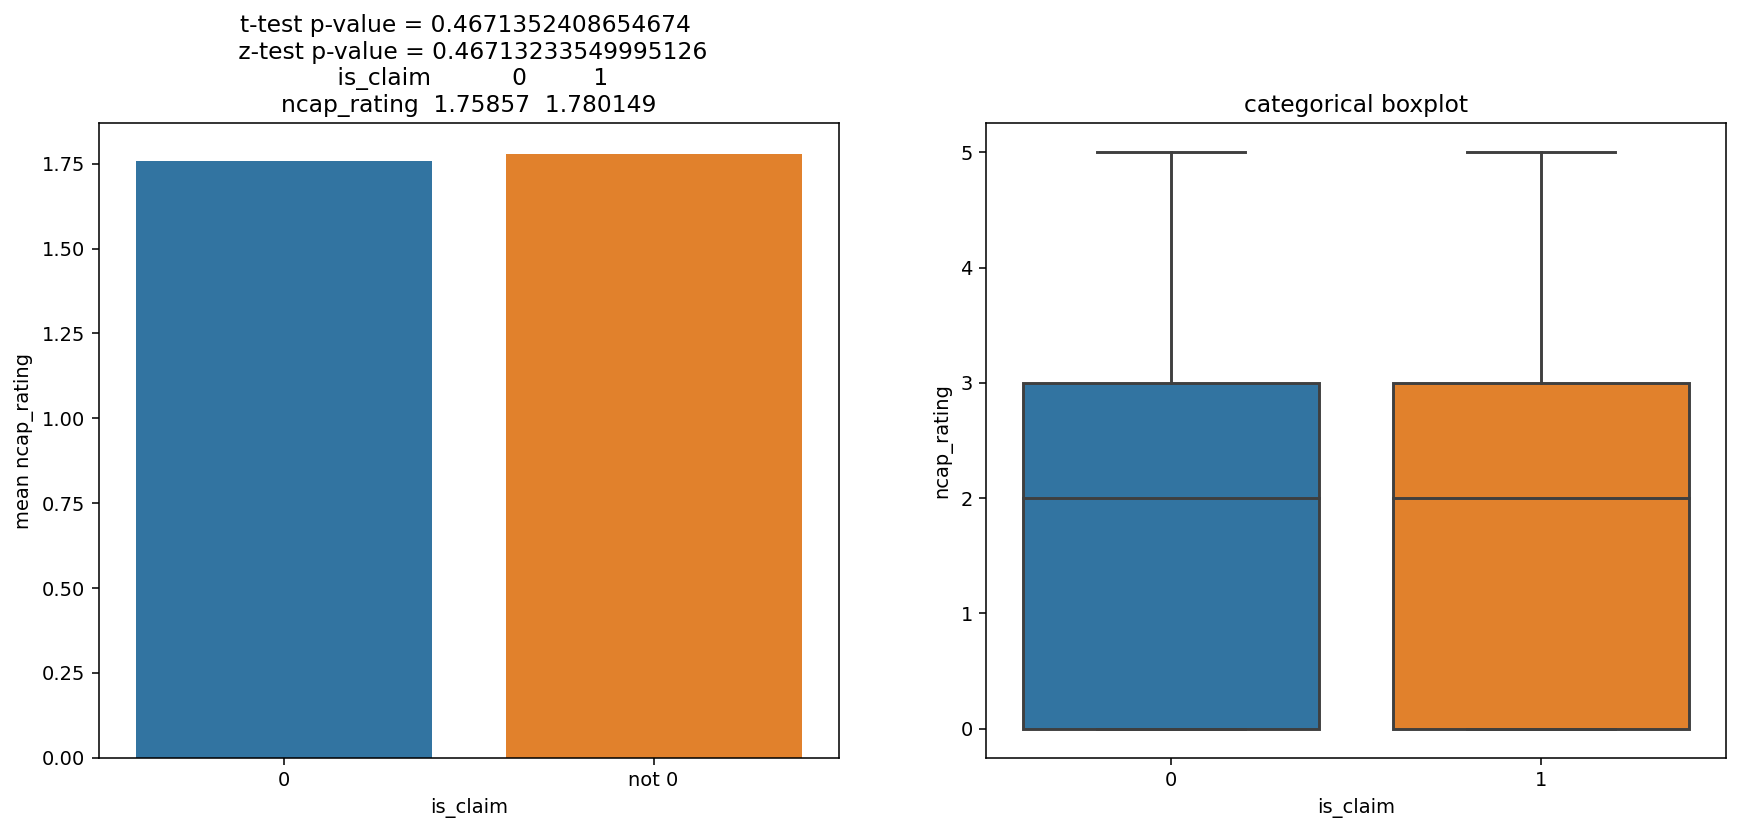

In [49]:
for i in list(numerical_cols):
    Bivariate_cont_cat(df_train, i, 'is_claim',0)

#### *Bivariate Analysis : Categorical-Categorical*

In [50]:
def BVA_categorical_plot(data, tar, cat):
  '''
  take data and two categorical variables,
  calculates the chi2 significance between the two variables 
  and prints the result with countplot & CrossTab
  '''
  #isolating the variables
  data = data[[cat,tar]][:]

  #forming a crosstab
  table = pd.crosstab(data[tar],data[cat],)
  f_obs = np.array([table.iloc[0][:].values,
                    table.iloc[1][:].values])

  #performing chi2 test
  from scipy.stats import chi2_contingency
  chi, p, dof, expected = chi2_contingency(f_obs)
  
  #checking whether results are significant
  if p<0.05:
    sig = True
  else:
    sig = False

  #plotting grouped plot
  sns.countplot(x=cat, hue=tar, data=data)
  plt.title("p-value = {}\n difference significant? = {}\n".format(round(p,8),sig))

  #plotting percent stacked bar plot
  #sns.catplot(ax, kind='stacked')
  ax1 = data.groupby(cat)[tar].value_counts(normalize=True).unstack()
  ax1.plot(kind='bar', stacked='True',title=str(ax1))
  int_level = data[cat].value_counts()

In [51]:
list(categorical_cols)

['policy_id',
 'area_cluster',
 'segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'transmission_type',
 'steering_type',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert']

In [53]:
cats_lst=['area_cluster',
          'segment',
          'model',
          'fuel_type',
          'max_torque',
          'max_power',
          'engine_type',
          'is_esc',
          'is_adjustable_steering',
          'is_tpms',
          'is_parking_sensors',
          'is_parking_camera',
          'rear_brakes_type',
          'transmission_type',
          'steering_type',
          'is_front_fog_lights',
          'is_rear_window_wiper',
          'is_rear_window_washer',
          'is_rear_window_defogger',
          'is_brake_assist',
          'is_power_door_locks',
          'is_central_locking',
          'is_power_steering',
          'is_driver_seat_height_adjustable',
          'is_day_night_rear_view_mirror',
          'is_ecw',
          'is_speed_alert']

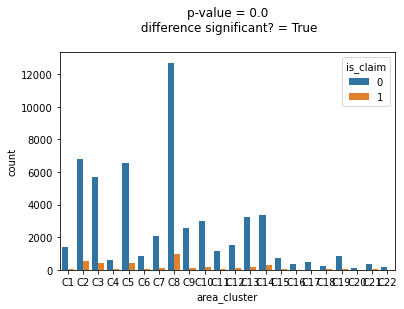

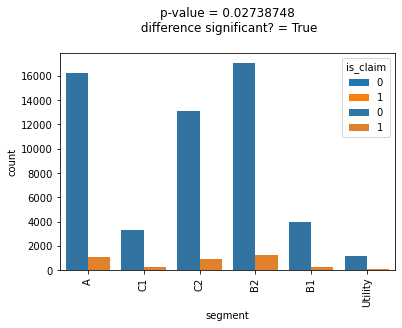

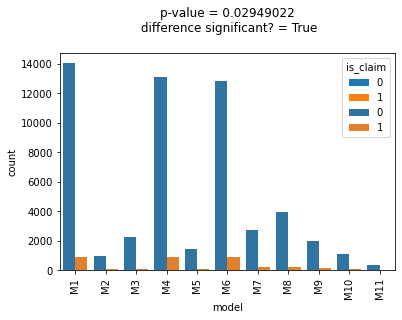

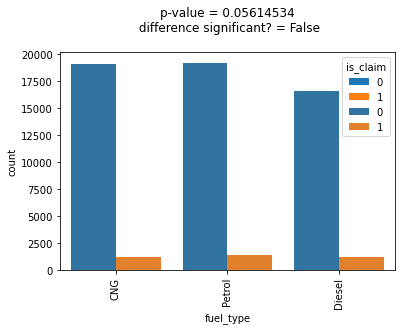

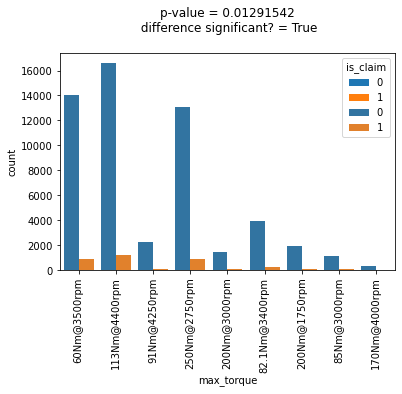

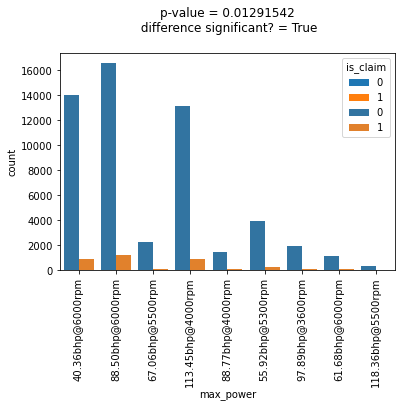

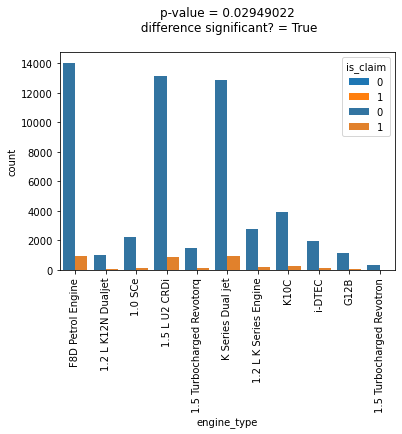

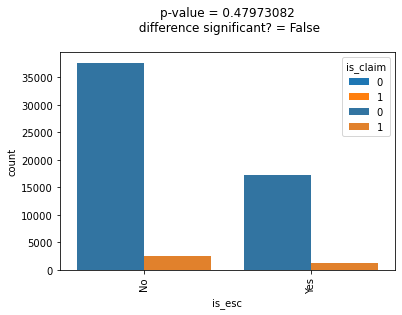

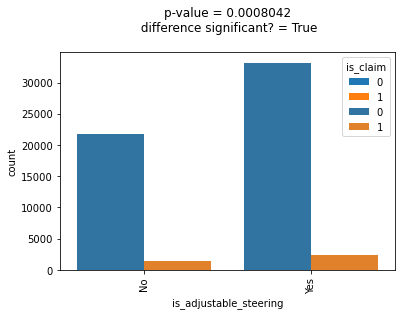

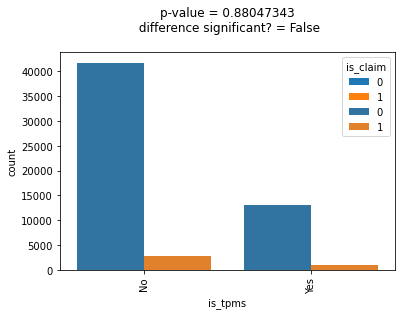

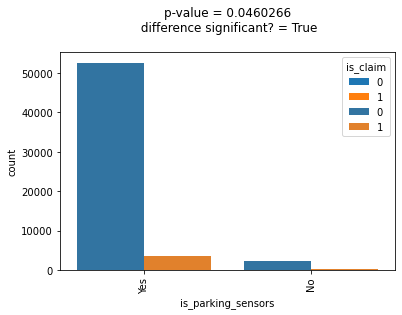

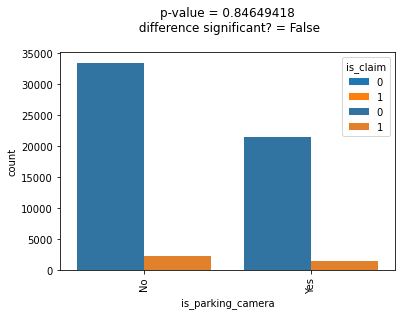

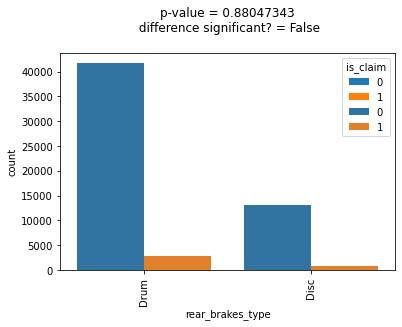

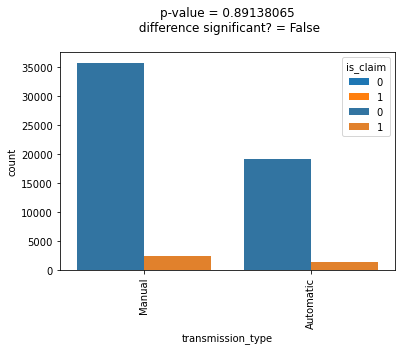

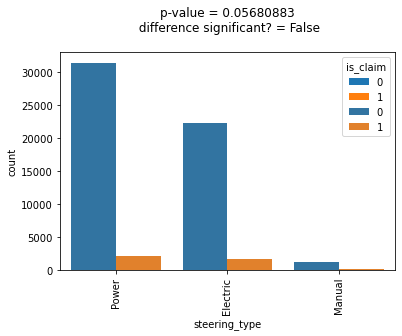

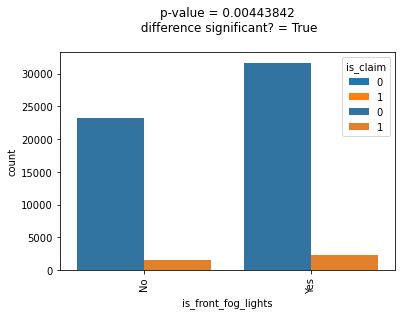

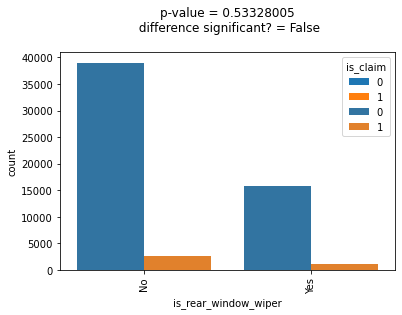

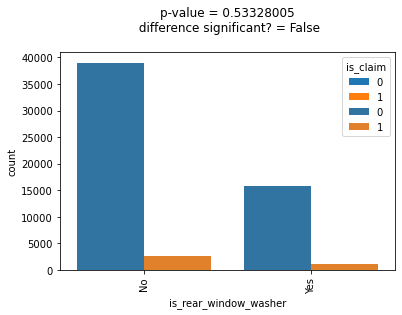

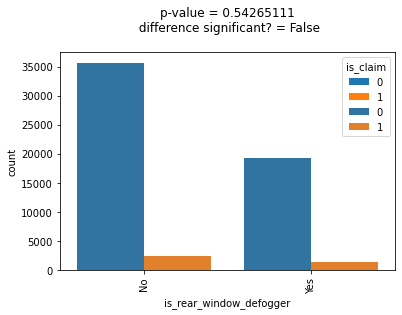

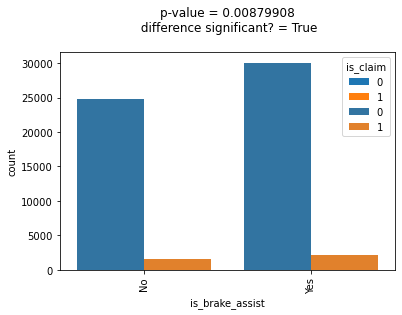

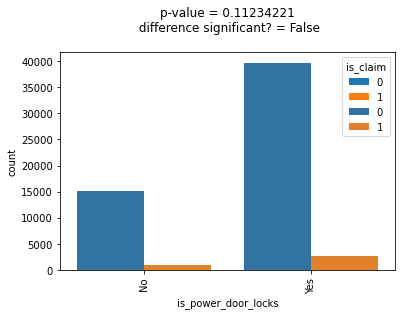

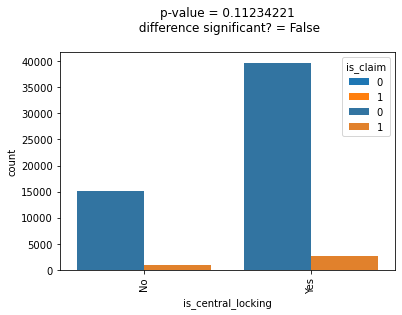

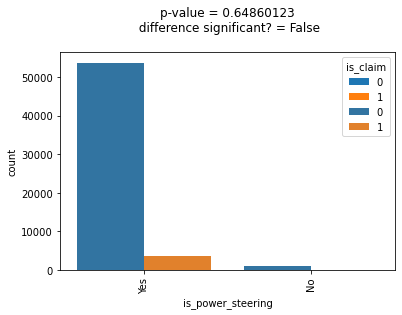

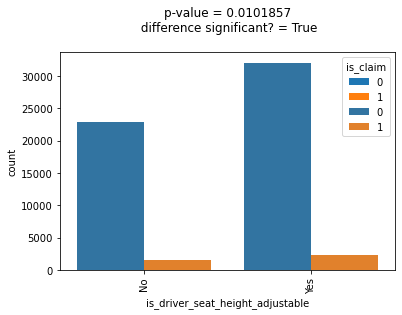

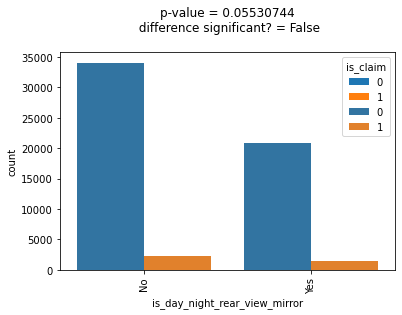

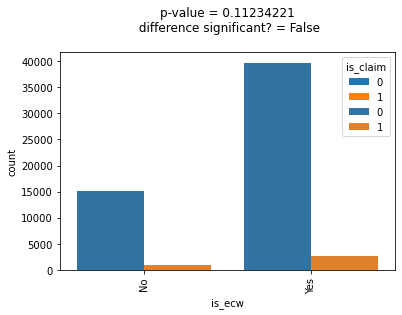

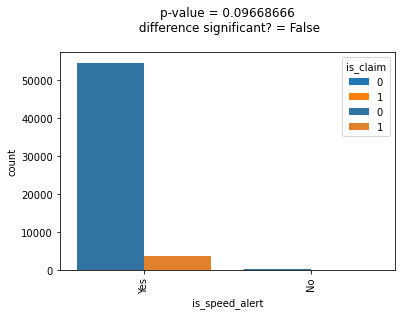

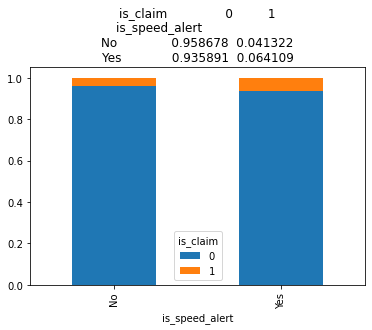

In [54]:
for i in cats_lst:
    BVA_categorical_plot(df_train, 'is_claim', i)

## Multivariate Analysis

# Modelling

## Get Dummies

## Features and Target Variable


In [ ]:
y = df_train['*********']
features = ['************']
X = df_train[features]

## Train Test Split

In [2]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True,  stratify=y)

In [29]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((750, 10), (250, 10), (750,), (250,))

## Scaling

In [6]:
from sklearn.preprocessing  import MinMaxScaler

In [7]:
scalar = MinMaxScaler()

## building A Dummy Classifier

In [30]:
from sklearn.dummy import DummyClassifier

In [32]:
# create a dummy classifier
dummy_model = DummyClassifier(strategy='uniform', random_state=42)

# Train the Model
dummy_model.fit(x_train, y_train)

# predict for the validation train data
dummy_preds = dummy_model.predict(x_test)

# get accuracy score 
# compare predicted values to the actual val_test values
dummy_score = dummy_model.score(dummy_preds, y_test)
print('Baseline Dummy Classifier score is {} %'.format(round(dummy_score*100,2)))

Baseline Dummy Classifier score is 50.8 %


## Evaluate Multiple Models

In [80]:
#Modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [96]:
def test_mulitple_models(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    
    xgb, RF, gbm = XGBClassifier(), RandomForestClassifier(), GradientBoostingClassifier()
    voting_classifier = VotingClassifier(estimators=[('XGB', xgb), ('RF', RF), ('GBM', gbm)], voting='hard')
    
    models = [
              ('LogReg', LogisticRegression()), 
              ('RF', RandomForestClassifier()),
              ('KNN', KNeighborsClassifier()),
              ('SVM', SVC()), 
              ('GNB', GaussianNB()),
              ('XGB', XGBClassifier()),
              ('v_classifier', voting_classifier)
            ]
    
    results = []
    names = []
    Test_Accuracy = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ["Not Survived", 'Survived']

    for name, model in models[:-1]:

        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
        
        # fit the model
        clf = model.fit(X_train, y_train)
        
        # Predict for validation set
        y_pred = clf.predict(X_test)
        
        print(f"****************************** {name} **************************" )
        print(classification_report(y_test, y_pred, target_names=target_names))

        results.append(cv_results)
    
        Test_Accuracy.append(cv_results.get('test_accuracy')) # retreiving test scores from the cv_results dictionary output
        names.append(name)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

    final = pd.concat(dfs, ignore_index=True)
    Final_mean_score = final.groupby('model').mean()
    Final_mean_score.reset_index(inplace=True)
    
    # boxplot algorithm comparison
    fig = plt.figure(figsize=(8,8))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(Test_Accuracy)
    ax.set_xticklabels(names)
    
    plt.show()

    return final, Final_mean_score

{'fit_time': array([0.7796154 , 0.81082392, 0.83077431, 0.81481981, 0.9014082 ]), 'score_time': array([0.04114127, 0.04189348, 0.04199576, 0.04199266, 0.031914  ]), 'test_accuracy': array([nan, nan, nan, nan, nan]), 'test_precision_weighted': array([nan, nan, nan, nan, nan]), 'test_recall_weighted': array([nan, nan, nan, nan, nan]), 'test_f1_weighted': array([nan, nan, nan, nan, nan]), 'test_roc_auc': array([nan, nan, nan, nan, nan])}
[12:44:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
****************************** v_classifier **************************
              precision    recall  f1-score   support

Not Survived       0.87      0.97      0.92       125
    Survived       0.96      0.86      0.91       125

    accuracy    

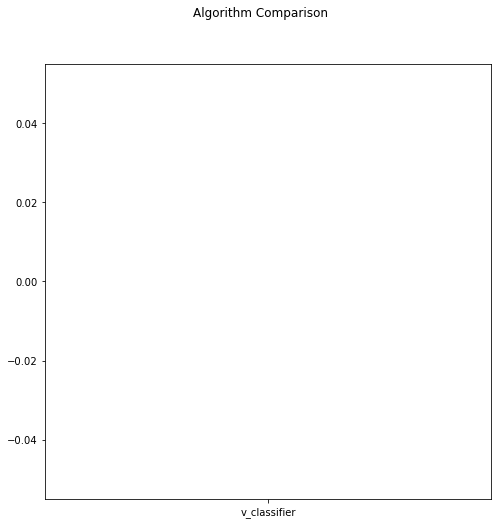

(   fit_time  score_time  test_accuracy  test_precision_weighted  \
 0  0.779615    0.041141            NaN                      NaN   
 1  0.810824    0.041893            NaN                      NaN   
 2  0.830774    0.041996            NaN                      NaN   
 3  0.814820    0.041993            NaN                      NaN   
 4  0.901408    0.031914            NaN                      NaN   
 
    test_recall_weighted  test_f1_weighted  test_roc_auc         model  
 0                   NaN               NaN           NaN  v_classifier  
 1                   NaN               NaN           NaN  v_classifier  
 2                   NaN               NaN           NaN  v_classifier  
 3                   NaN               NaN           NaN  v_classifier  
 4                   NaN               NaN           NaN  v_classifier  ,
           model  fit_time  score_time  test_accuracy  test_precision_weighted  \
 0  v_classifier  0.827488    0.039787            NaN                

In [93]:
test_mulitple_models(x_train, y_train, x_test, y_test)

****************************** LogReg **************************
              precision    recall  f1-score   support

Not Survived       0.80      0.87      0.84       125
    Survived       0.86      0.78      0.82       125

    accuracy                           0.83       250
   macro avg       0.83      0.83      0.83       250
weighted avg       0.83      0.83      0.83       250

****************************** RF **************************
              precision    recall  f1-score   support

Not Survived       0.86      0.95      0.90       125
    Survived       0.95      0.85      0.89       125

    accuracy                           0.90       250
   macro avg       0.90      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250

****************************** KNN **************************
              precision    recall  f1-score   support

Not Survived       0.81      0.90      0.85       125
    Survived       0.89      0.78      0.83      

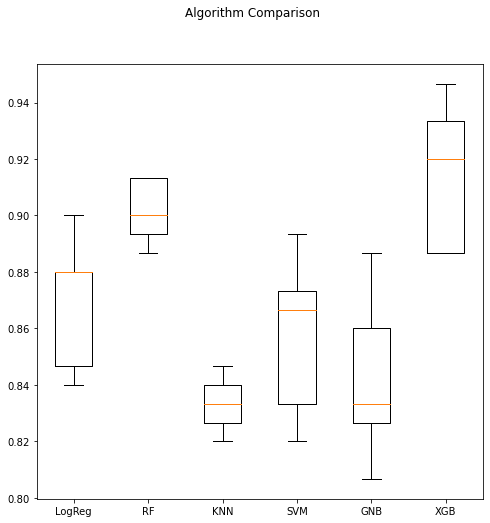

In [97]:
df_output, df_Output_mean_scores = test_mulitple_models(x_train, y_train, x_test, y_test)

### Compare Models Performance

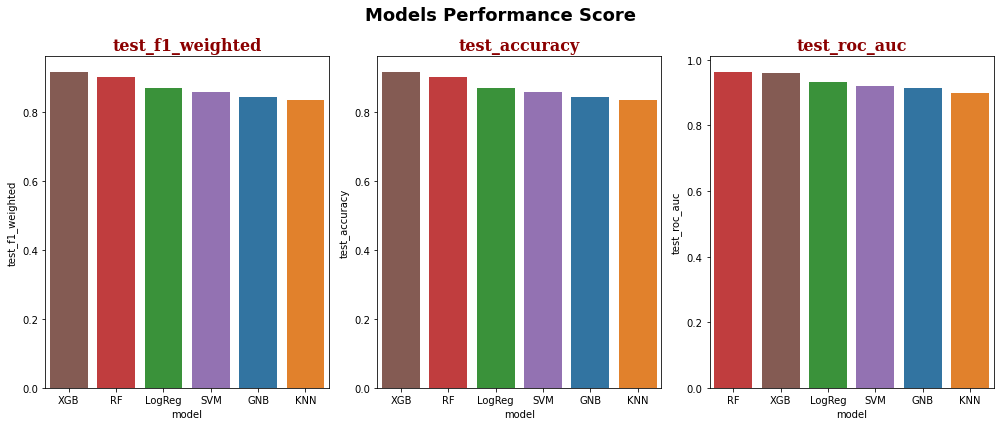

In [98]:
# create fontdicts for formatting figure text
axtitle_dict = {'family': 'serif','color':  'darkred','weight': 'bold','size': 16}
axlab_dict = {'family': 'serif', 'color': 'black','size': 14}

df_plots = df_Output_mean_scores[['model','test_f1_weighted' , 'test_accuracy', 'test_roc_auc']]
accuracy_columns = ['test_f1_weighted' , 'test_accuracy', 'test_roc_auc']

fig = plt.figure(figsize=[14,6])
fig.suptitle('Models Performance Score', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);

for i ,col in enumerate(accuracy_columns):
    a = fig.add_subplot(1, 3, i+1)
    sns.barplot(data = df_plots, x = 'model', y = col, hue ='model',
                     order =df_plots.sort_values(col, ascending=False)['model'],
                     dodge=False, ax =a)

    a.set_title(col , fontdict=axtitle_dict)
    a.legend([],[], frameon=False) # Remove Legend
    plt.tight_layout()

# Model Improvement

-  We can start with Grid search to get a sense of the model's optimum performance based on the selected features
-  The apply feature elimination, if these fails,

-  We can use Feature Engineering to create new features:
    -  then redo train test split,
    -  retrain the model/s,
    -  Check the score/s
-  After, we can redo Gridsearch with these new features and explore if the model's accuracy will change
-  We can also do feature elimination coupled with Grid or Random Search

## Grid Search

In [12]:
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time
chosen_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# defining a dictionary
parameter_grid = {'n_estimators' : [100, 150, 200, 250],
                    'max_depth' : [5, 8, 15, 25],
                    'min_samples_split' : [2, 5, 10, 15, 30],
                    'min_samples_leaf' : [1, 2, 5, 10]
                        }

grid_search = GridSearchCV(chosen_model, param_grid=parameter_grid, cv = 5, verbose = 0, 
                      n_jobs = -1)
# Fit gridsearch
best_params = grid_search.fit(x_train, y_train)
print(best_params)

In [ ]:
# best parameters according to grid search
best_params.best_params_

In [ ]:
# fit the best model with new parameters from gridsearch
chosen_model = RandomForestClassifier(random_state = 42, max_depth= 8,
                                         min_samples_leaf= 1,
                                         min_samples_split= 2,
                                         n_estimators= 100, n_jobs= -1) 

# fit the model
model_chosen_model = chosen_model.fit(x_train, y_train) 

# predict for val_train
y_pred_optimized_2 = model_chosen_model.predict(x_test)

# get accuray score
optimized_score_2 = accuracy_score(y_pred_optimized_2, y_test)
print("The accuracy score is: ", round(optimized_score_2,2))

### Feature Importance

## Feature Elimination

In [13]:
from sklearn.feature_selection import RFECV

In [ ]:
%%time
features = x_train.copy()
target = x_test.copy()


rfecv = RFECV(estimator=RF, step=1, cv=5, n_jobs=-1, min_features_to_select=3)
rfecv.fit(features, target)
rfecv.transform(features)

In [ ]:
# rank features
rank = rfecv.ranking_.tolist()
best_features = rfecv.support_.tolist()

# create a dataframe for the ranked features
RankFeatures = pd.DataFrame({'columns':features.columns.tolist()[:],
                             'feature_rank':rank,
                             'best_feature':best_features}).sort_values(by='feature_rank', ascending=True).reset_index(drop=True)

In [ ]:
RankFeatures